# Five Baseflow Separation Methods:
#### (1) Numerical method
#### (2) SC mass balance method
#### (3) Digital filter method
#### (4) UKIH method
#### (5) PH graphical method

### Pip install functions

In [1]:
# !pip install modvis
# !pip install baseflow==0.0.9
# !pip install hydroeval
# !pip install dataretrieval

In [2]:
import h5py
import baseflow
from modvis import ATSutils
from modvis import utils
from modvis import general_plots as gp
import pandas as pd
import numpy as np
from dataretrieval import nwis
from dataretrieval import wqp
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from scipy import stats


from scipy.optimize import curve_fit
from scipy.stats import linregress
import h5py
import sys, os
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from tqdm import tqdm
from pathlib import Path
from baseflow.methods import *
from baseflow.comparision import strict_baseflow, KGE
from baseflow.utils import clean_streamflow, exist_ice, geo2imagexy, format_method
from baseflow.param_estimate import recession_coefficient, param_calibrate, maxmium_BFI

from hydroeval import evaluator, nse, kge

surf_area = 53159325.46184719 # in square meters
area = 20.3 #square miles
fontsize = 14

#### Make a folder

In [3]:
os.makedirs("figures", exist_ok=True)

# (1) Numerical model results and baseflow calculations: 

## Reading 'base_calibrated-wb-2014_2022-GW.csv'

In [4]:
df = pd.read_csv(os.path.join('base_calibrated-wb-2014_2022-GW.csv'), comment='#')

df['datetime'] = pd.to_datetime(df['datetime'])
df = df[(df['datetime'] >= '2015-10-01') & (df['datetime'] <= '2022-09-30')]


## Convert data to cms and plot it

In [5]:
df['watershed boundary discharge [m3 s^-1]'] = df['watershed boundary discharge [mol d^-1]']/55500/24/60/60

df['exfiltration [m3 s^-1]'] = df['exfiltration [mol d^-1]']/55500/24/60/60

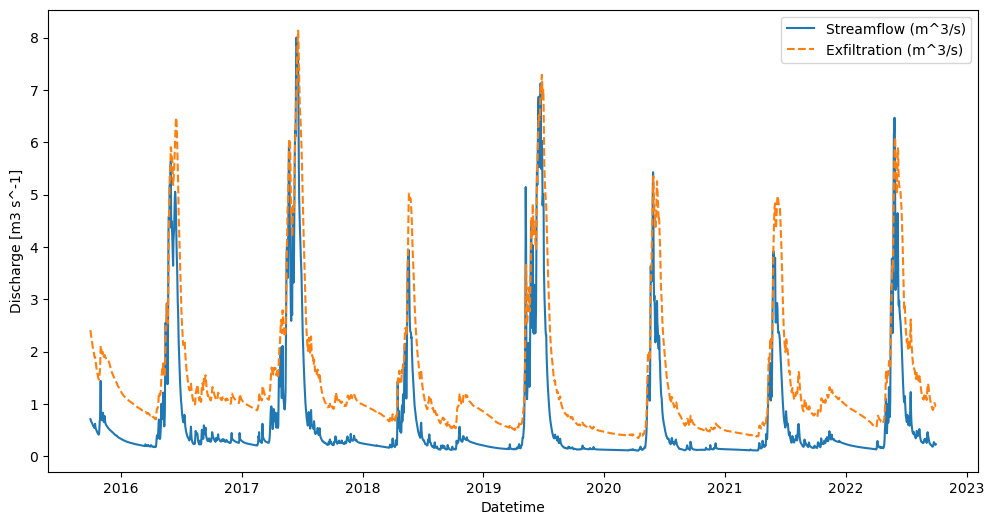

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(df['datetime'], df['watershed boundary discharge [m3 s^-1]'], label='Streamflow (m^3/s)')
plt.plot(df['datetime'], df['exfiltration [m3 s^-1]'], label='Exfiltration (m^3/s)', linestyle='--')

# Adding labels and title
plt.xlabel('Datetime')
plt.ylabel('Discharge [m3 s^-1]')

# Adding legend
plt.legend()
plt.show()

#### The total exfiltration in the figure above is higher than the total discharge due to reexfiltration. The total exfiltration now equals the sum of baseflow and reexfiltration.

##### First, demonstrate the presence of reinfiltration leading to reexfiltration by plotting both exfiltration and infiltration. If infiltration during the dry season is not zero, this indicates reinfiltration. We then assume that the amount of reinfiltration is equal to the exfiltration. Therefore, once reinfiltration is confirmed, it is assumed to be equal to the reexfiltration. 

## Proving the existence of re-infiltration and calculating the dry period baseflow:
##### Assume that the infiltration is zero when rainfall and snowmelt are zero. filter the rows that apply these conditions and assume that the baseflow is equal to water content change - transpiration. Plot the baseflow of the dry period

In [7]:
df['infiltration [m d^-1]'] =  df['infiltration [mol d^-1]']/55500./surf_area
df['net runoff [m d^-1]'] = df['net runoff [mol d^-1]']/55500./surf_area
df['subsurface water content [m]'] = df['subsurface water content [mol]'] / 55500 / surf_area
df['subsurface water content change [m d^-1]'] = df['subsurface water content [m]'].diff()

## If it is a dry period (when precipitation and snowmelt are zero), the baseflow equals the negative of the subsurface water content change
## This equation calculates the baseflow during dry periods only, leaving the values blank for all other conditions

df['GW_discharge [m d^-1]'] =  -df['subsurface water content change [m d^-1]'] - df['transpiration [m d^-1]']
df['GW_discharge_new_dryperiod [m d^-1]'] = df.apply(
    lambda row: row['GW_discharge [m d^-1]'] if row['snowmelt [m d^-1]'] == 0 and row['rain precipitation [m d^-1]'] == 0 
    else np.nan,
    axis=1)

df['reinfiltration_new_dryperiod [m d^-1]'] = df.apply(
    lambda row: row['exfiltration [m d^-1]'] - row['GW_discharge_new_dryperiod [m d^-1]'] if row['snowmelt [m d^-1]'] == 0 and row['rain precipitation [m d^-1]'] == 0 
    else np.nan,
    axis=1)

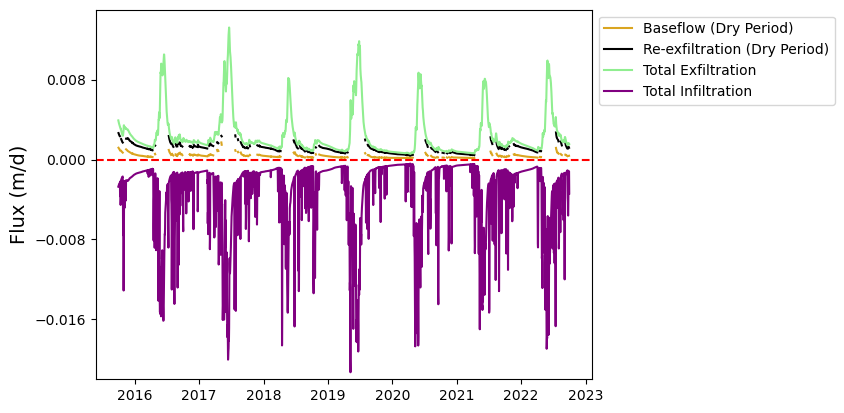

In [8]:
fig, ax1 = plt.subplots()


ax1.plot(df['datetime'], df['GW_discharge_new_dryperiod [m d^-1]'], label='Baseflow (Dry Period)', color='#DAA520')
ax1.plot(df['datetime'], df['reinfiltration_new_dryperiod [m d^-1]'], label='Re-exfiltration (Dry Period)', color='black')
ax1.plot(df['datetime'], df['exfiltration [m d^-1]'], label='Total Exfiltration', color='lightgreen')
ax1.plot(df['datetime'], df['infiltration [m d^-1]'], label='Total Infiltration', color='purple')


ax1.axhline(y=0, color='red', linestyle='--')


ax1.set_ylabel('Flux (m/d)', fontsize = fontsize)
ax1.set_ylim(-0.022, 0.015)
ax1.set_yticks(np.arange(-0.02, 0.02, 0.01))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=6))

# Legend
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save and show plot
plt.savefig('figures/reinfiltration_proof', dpi=500, bbox_inches='tight')
plt.show()


#### Find the relationship between reinfiltration and streamflow. Use this relationship to find the continuous reinfiltration and then plot baseflow = exfiltration - reinfiltration

#### Linear relationship

In [9]:
filtered_df = df.dropna(subset=['reinfiltration_new_dryperiod [m d^-1]'])

x = filtered_df['exfiltration [m d^-1]']
y = filtered_df['reinfiltration_new_dryperiod [m d^-1]']


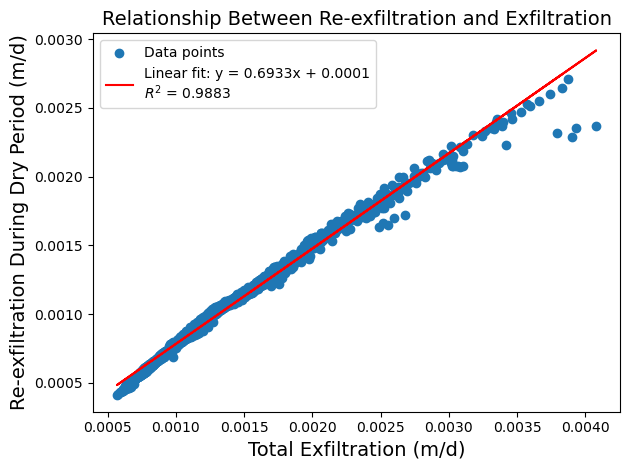

In [10]:

plt.figure()
plt.scatter(x, y, label='Data points')
plt.xlabel('Total Exfiltration (m/d)', fontsize = fontsize)
plt.ylabel('Re-exfiltration During Dry Period (m/d)', fontsize = fontsize)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.plot(x, slope * x + intercept, color='red', label=f'Linear fit: y = {slope:.4f}x + {intercept:.4f}\n$R^2$ = {r_value**2:.4f}')



plt.legend()



plt.title('Relationship Between Re-exfiltration and Exfiltration', fontsize = fontsize)

plt.tight_layout()

plt.savefig('figures/Relationship_Between_Re-exfiltration_and_Exfiltration',dpi = 500)
plt.show()


In [11]:
df['daily_reinfiltration_lin [m d^-1]'] = 0.6933 * df['exfiltration [m d^-1]'] + 0.0001
df['baseflow_lin [m d^-1]'] = df['exfiltration [m d^-1]'] - df['daily_reinfiltration_lin [m d^-1]']


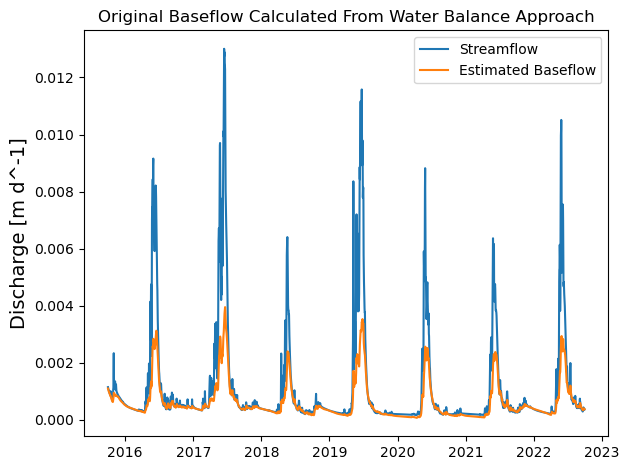

In [12]:
plt.figure()
plt.plot(df['datetime'], df['net runoff [m d^-1]'], label='Streamflow')


plt.plot(df['datetime'], df['baseflow_lin [m d^-1]'], label='Estimated Baseflow')

plt.ylabel('Discharge [m d^-1]', fontsize = fontsize)
plt.title('Original Baseflow Calculated From Water Balance Approach')
plt.legend()


plt.tight_layout()
plt.show()


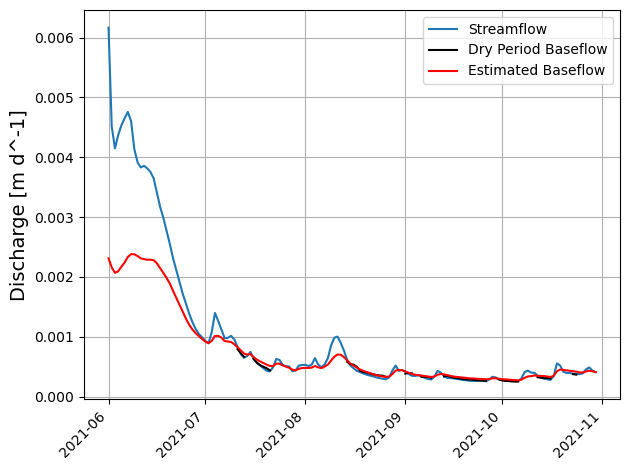

In [13]:

start_date = '2021-06-01'
end_date = '2021-10-30'
filtered_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

plt.figure()
plt.plot(filtered_df['datetime'], filtered_df['net runoff [m d^-1]'], label='Streamflow')
plt.plot(filtered_df['datetime'], filtered_df['GW_discharge_new_dryperiod [m d^-1]'], label='Dry Period Baseflow', color = 'black')


plt.plot(filtered_df['datetime'], filtered_df['baseflow_lin [m d^-1]'], label='Estimated Baseflow', color='red')

plt.ylabel('Discharge [m d^-1]', fontsize = fontsize)

plt.legend()
# plt.ylim(0, 0.003)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### The figures above show that the estimated baseflow might exceed the streamflow in low flow periods, thus, baseflow is removed for the days of sxceedance. These are the following steps:

#### Checking if there are days of baseflow greater than streamflow
#### Find the average exceedance
#### Find the exceedance days per each month of each year and the average exceedance

In [14]:
df['baseflow_greater_than_runoff'] = df['baseflow_lin [m d^-1]'] > df['net runoff [m d^-1]']
df['exceedance'] = df['baseflow_lin [m d^-1]'] - df['net runoff [m d^-1]']
df['percentage_exceedance'] = (df['exceedance'] / df['net runoff [m d^-1]']) * 100

exceedance_df = df[df['baseflow_greater_than_runoff']]

dates_with_condition = exceedance_df[['datetime', 'percentage_exceedance']]


In [15]:
# Calculating the exceedance days for each month:
overall_percentage_exceedance = exceedance_df['percentage_exceedance'].mean()
exceedance_df['year_month'] = exceedance_df['datetime'].dt.to_period('M')
grouped = exceedance_df.groupby('year_month').agg(
    days_of_exceedance=('percentage_exceedance', 'size'),
    average_exceedance=('percentage_exceedance', 'mean')
).reset_index()

C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\4209625419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exceedance_df['year_month'] = exceedance_df['datetime'].dt.to_period('M')


In [16]:
exceedance_df['month'] = exceedance_df['datetime'].dt.month

grouped_monthly = exceedance_df.groupby('month').agg(
    days_of_exceedance=('percentage_exceedance', 'size'),
    average_exceedance=('percentage_exceedance', 'mean'),
    min_exceedance=('percentage_exceedance', 'min'),
    max_exceedance=('percentage_exceedance', 'max'),
    stddev_exceedance=('percentage_exceedance', 'std')
).reset_index()
grouped_monthly

C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\2264363536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exceedance_df['month'] = exceedance_df['datetime'].dt.month


,month,days_of_exceedance,average_exceedance,min_exceedance,max_exceedance,stddev_exceedance
0,1,67,2.878652,0.034627,7.161801,2.600682
1,2,87,2.890047,0.026023,7.173408,2.006428
2,3,36,2.747454,0.228552,6.089564,1.800349
3,6,9,6.507989,0.266587,9.738908,2.767348
4,7,88,7.359262,0.236338,23.918955,5.625061
5,8,115,10.961142,0.001310,29.853322,6.494202
6,9,100,9.059206,0.156472,24.072435,6.435455
7,10,33,6.076839,0.214422,16.814227,4.579696
8,11,2,1.379324,0.756540,2.002109,0.880751
9,12,23,1.123214,0.012133,2.692765,0.945425


In [17]:
df['final_baseflow [m d^-1]'] = np.where(
    df['baseflow_greater_than_runoff'] & df['reinfiltration_new_dryperiod [m d^-1]'].notna(),
    df['GW_discharge_new_dryperiod [m d^-1]'],
    df['baseflow_lin [m d^-1]']
)

In [18]:
df['baseflow_greater_than_runoff_final'] = df['final_baseflow [m d^-1]'] > df['net runoff [m d^-1]']
dates_with_condition_final = df[df['baseflow_greater_than_runoff_final']]['datetime']


#### Setting the rows that still have baseflow greater than streamflow to be equal to the streamflow: 

In [19]:
# Replace in daily units (recommended to avoid rounding twice)
mask = df['baseflow_greater_than_runoff_final'].fillna(False)
df.loc[mask, 'final_baseflow [m d^-1]'] = df.loc[mask, 'net runoff [m d^-1]']

# Convert to m3/s
sec_per_day = 24 * 60 * 60
df['net runoff [m3 s^-1]']     = df['net runoff [m d^-1]'] * surf_area / sec_per_day
df['final_baseflow [m3 s^-1]'] = df['final_baseflow [m d^-1]'] * surf_area / sec_per_day


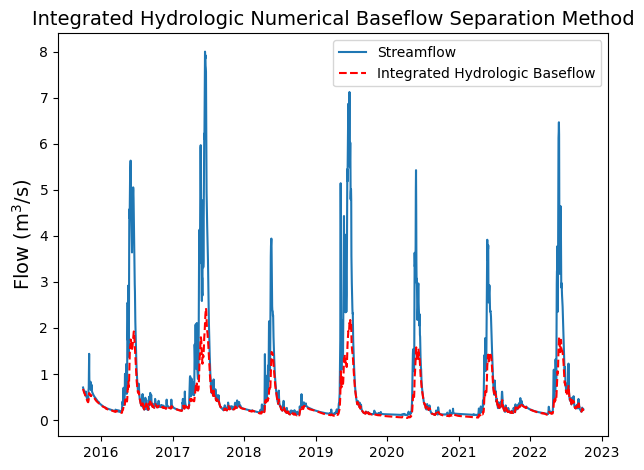

In [20]:
plt.figure()
plt.plot(df['datetime'], df['net runoff [m3 s^-1]'], label='Streamflow')
plt.plot(df['datetime'], df['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--')

plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)
plt.legend()
plt.title('Integrated Hydrologic Numerical Baseflow Separation Method', fontsize = fontsize)
plt.tight_layout()
plt.savefig('figures/final_baseflow_numerical_method', dpi = 500)
plt.show()

#### Plotting the baseflow for three different years separately: 2016-2017, 2017-2018, and 2021. Change the startdate and the enddate

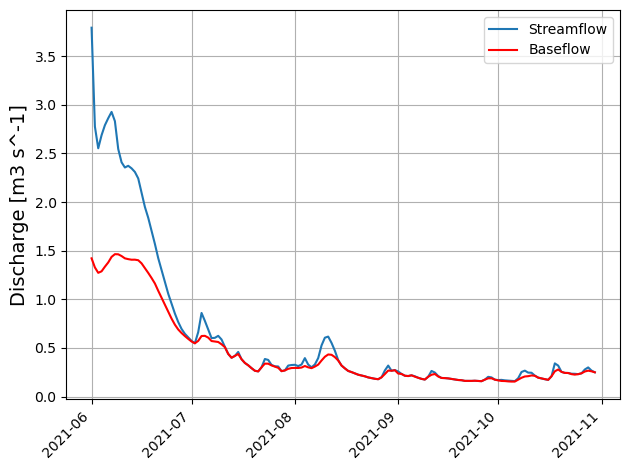

In [21]:
startdate = '2021-06-01'
enddate = '2021-10-30'
filtereddf = df[(df['datetime'] >= startdate) & (df['datetime'] <= enddate)]

plt.figure()
plt.plot(filtereddf['datetime'], filtereddf['net runoff [m3 s^-1]'], label='Streamflow')
plt.plot(filtereddf['datetime'], filtereddf['final_baseflow [m3 s^-1]'], label='Baseflow', color='red')


plt.ylabel('Discharge [m3 s^-1]', fontsize = fontsize)

plt.legend()

plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45, ha='right')
plt.tight_layout()
plt.show()


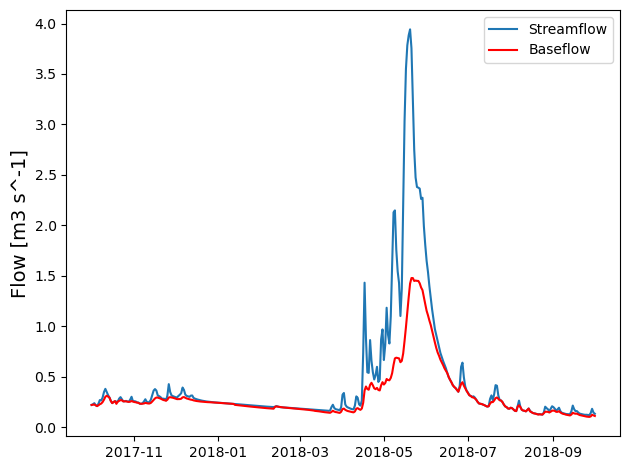

In [22]:
startdate = '2017-10-01'
enddate = '2018-10-01'
filtereddf = df[(df['datetime'] >= startdate) & (df['datetime'] <= enddate)]

plt.figure()
plt.plot(filtereddf['datetime'], filtereddf['net runoff [m3 s^-1]'], label='Streamflow')
plt.plot(filtereddf['datetime'], filtereddf['final_baseflow [m3 s^-1]'], label='Baseflow', color='red')


plt.ylabel('Flow [m3 s^-1]', fontsize = fontsize)

plt.legend()

plt.tight_layout()
plt.show()

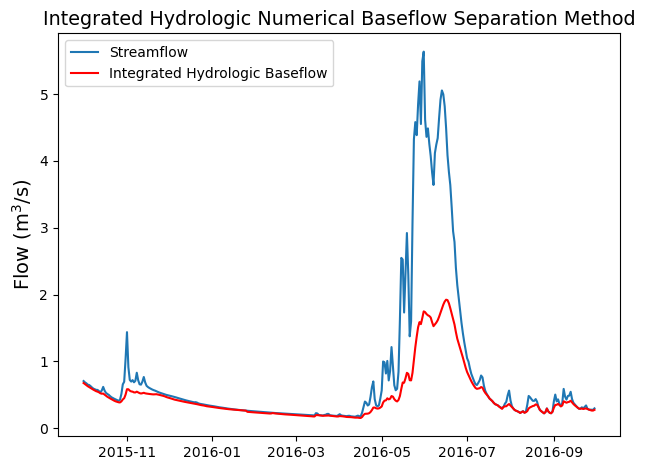

In [23]:
startdate = '2015-10-01'
enddate = '2016-09-30'
filtereddf = df[(df['datetime'] >= startdate) & (df['datetime'] <= enddate)]

plt.figure()
plt.plot(filtereddf['datetime'], filtereddf['net runoff [m3 s^-1]'], label='Streamflow')
plt.plot(filtereddf['datetime'], filtereddf['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red')


plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)

plt.legend()
plt.title('Integrated Hydrologic Numerical Baseflow Separation Method', fontsize = 13.84)
plt.tight_layout()
plt.show()

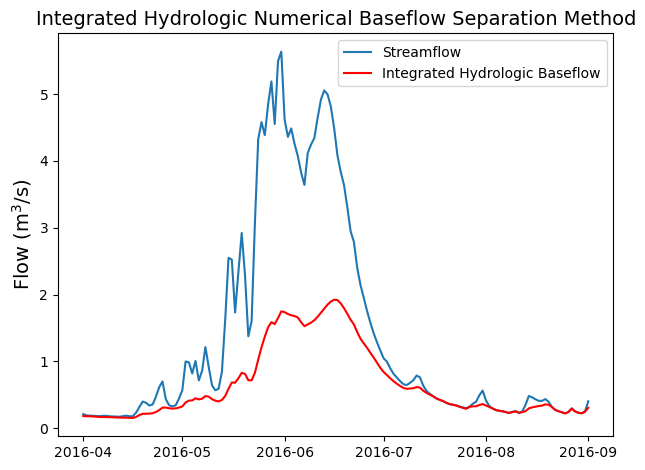

In [24]:
startdate = '2016-04-01'
enddate = '2016-09-01'
filtereddf = df[(df['datetime'] >= startdate) & (df['datetime'] <= enddate)]

plt.figure()
plt.plot(filtereddf['datetime'], filtereddf['net runoff [m3 s^-1]'], label='Streamflow')
plt.plot(filtereddf['datetime'], filtereddf['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red')


plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)

plt.legend()
plt.title('Integrated Hydrologic Numerical Baseflow Separation Method', fontsize = 13.95)
plt.tight_layout()
plt.show()

## Applying recession analysis to find the recession constant: 

## Plotting observed streamflow

#### Due to update in NWIS function, the line below doesnt work. So it is commented out, and a different way was applied to be able to use NWIS to retrieve the observed streamflow

In [25]:
# obs_df = utils.load_nwis(sites= "09111250", start = '2015-10-01', end = '2022-10-01')

In [26]:
def load_nwis_daily(site="09111250", start="2015-10-01", end="2022-10-01", parameter="00060"):
    # Fetch daily mean streamflow
    raw_data = nwis.get_record(sites=site, service="dv", start=start, end=end, parameterCd=parameter)

    # Ensure datetime index and drop timezone if present
    if 'datetime' in raw_data.columns:
        raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])
        raw_data = raw_data.set_index('datetime')
    raw_data.index = pd.to_datetime(raw_data.index).tz_localize(None)

    # Choose the discharge column
    data_cols = [c for c in raw_data.columns if not c.endswith('_cd')]
    prefer = [c for c in data_cols if c.endswith('_00003') or c.endswith('_Mean') or c.endswith('_mean')]
    if prefer:
        col = prefer[0]
    else:
        cand = [c for c in data_cols if parameter in c] or data_cols
        col = cand[0]

    s = pd.to_numeric(raw_data[col], errors='coerce')
    s.name = "discharge_cfs"
    return s.to_frame()


obs_df = load_nwis_daily("09111250", "2015-10-01", "2022-10-01")


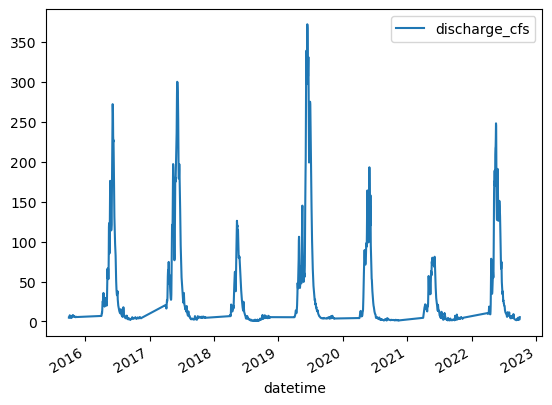

In [27]:
obs_df.plot()
plt.savefig('figures/obs_discharge.png')

In [28]:
obs_df["discharge_[m^3/d]"] = obs_df["discharge_cfs"] * 2446.575546
sim=df
sim = sim.set_index('datetime')

In [29]:
idx = sim.index.union(obs_df.index)

Q_sim  = sim.reindex(idx)['watershed boundary discharge [m^3/d]']
Q_obs  = obs_df.reindex(idx)['discharge_[m^3/d]']
rain   = sim.reindex(idx)['rain precipitation [m d^-1]'].fillna(0.0)
snow   = sim.reindex(idx)['snowmelt [m d^-1]'].fillna(0.0)

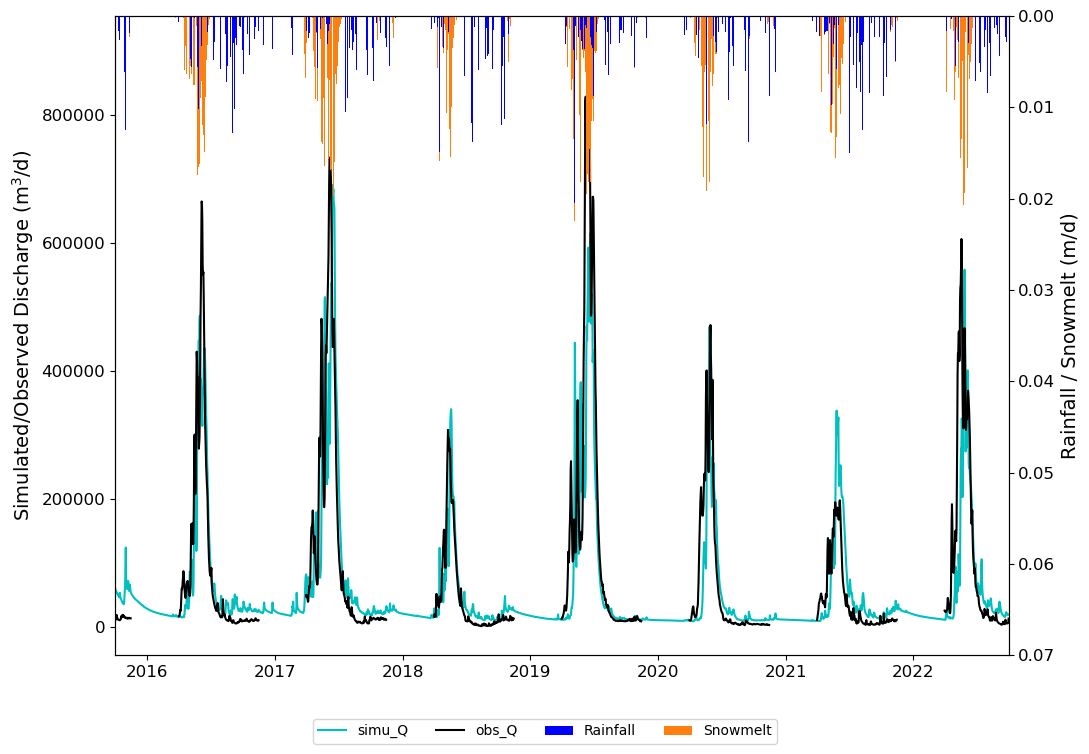

In [30]:
if len(idx) > 1:
    step_days = np.median(np.diff(mdates.date2num(idx)))
    barw = step_days * 0.9
else:
    barw = 0.8

fig, ax1 = plt.subplots(figsize=(11, 7))

# Discharge lines
line1, = ax1.plot(idx, Q_sim, color='c', label='simu_Q', zorder=2)
line2, = ax1.plot(idx, Q_obs, color='k', label='obs_Q', zorder=99)
ax1.set_ylabel(r'Simulated/Observed Discharge (m$^3$/d)', fontsize=fontsize)

# Rainfall & Snowmelt stacked bars on inverted twin axis
ax2 = ax1.twinx()
bar1 = ax2.bar(idx, rain, width=barw, color='b', label='Rainfall', linewidth=0)
bar2 = ax2.bar(idx, snow, width=barw, bottom=rain, color='#ff7f0e', label='Snowmelt', linewidth=0)

ax2.set_ylabel('Rainfall / Snowmelt (m/d)', fontsize=fontsize)
ax2.invert_yaxis()
ax2.set_ylim(0.07, 0.00)  


ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax1.set_xlim(idx.min(), idx.max())


handles = [line1, line2, bar1, bar2]
labels  = [h.get_label() for h in handles]
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.08))

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')

plt.tight_layout()
fig.savefig('figures/simu_obs_rain_snow.png', dpi=900, bbox_inches='tight', pad_inches=0.3)
plt.show()


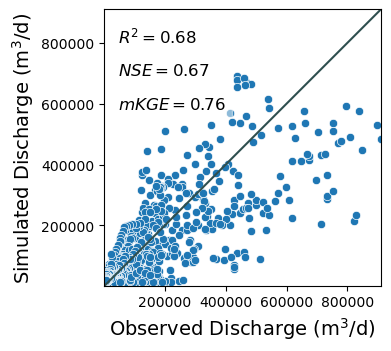

In [31]:

obs = obs_df['discharge_[m^3/d]']
simu = sim['watershed boundary discharge [m^3/d]']


aligned = (
    pd.concat([obs.rename('obs'), simu.rename('sim')], axis=1)
      .dropna()
)


aligned = aligned[aligned.index >= pd.to_datetime("2016-10-01")]

# One-to-one plot: observed first, simulated second
gp.one2one_plot(
    aligned['obs'],
    aligned['sim'],
    metrics=['R^2', 'NSE', 'mKGE'],
    show_density=False,
    start_date="2016-10-01"
)

# Labels and styling
fig = plt.gcf()
ax = plt.gca()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.set_xlabel('Observed Discharge (m$^3$/d)', fontsize=fontsize)
ax.set_ylabel('Simulated Discharge (m$^3$/d)', fontsize=fontsize)

plt.tight_layout()

fig.savefig('figures/one2one_simu_obs.png', dpi=500)


## Calculating the average streamflow for the water year 2021 and that of the whole period to know if the streamflow of this year is below average or not: 


In [32]:
average_total_period = df['net runoff [m3 s^-1]'].mean()

specific_period_df = df.loc['2020-10-01':'2021-10-01']
average_specific_period = specific_period_df['net runoff [m3 s^-1]'].mean()

print(f'Average Streamflow of the entire period of study (2016-2022): {average_total_period:.2f} m3/s')
print(f'Average Streamflow of the water year 2021: {average_specific_period:.2f} m3/s')

Average Streamflow of the entire period of study (2016-2022): 0.68 m3/s
Average Streamflow of the water year 2021: 0.11 m3/s


# (2) SC mass balance method

### Retrieving the specific conductivity data for '09111250 coal creek wattershed'

##### Retrieving the SC from the USGS: Due to the update and maintenance in USGS, the nwis.get_qwdata used in the cell below doesnt work now. So we extracted SC measurements from USGS into the spreadsheet SC_try

In [33]:
# retrieving Specific Conductivity data for Coal Creek


# Inputs for site, variable, and date range
# site = '09111250'  # for Coal Creek
# pcode = '00095'    # for specific conductivity
# startdate = '1990-01-01'
# enddate = '2024-02-07'

# Retrieve data 
# SC = nwis.get_qwdata(sites=site,
#                  parameterCd=pcode,
#                  startDt=startdate,
#                  endDt=enddate)


In [34]:
SC_try = pd.read_csv(os.path.join('SC_try.csv'), comment='#')


SC = SC_try[['Activity_StartDate', 'Result_Measure']].copy()
SC.rename(columns={'Activity_StartDate': 'datetime'}, inplace=True)
SC.rename(columns={'Result_Measure': 'p00095'}, inplace=True)


SC['datetime'] = pd.to_datetime(SC['datetime'])
SC = SC.sort_values(by='datetime').set_index('datetime')


### Merging the specific conductivity measurements to the dataframe of the daily discharge (simulated)

In [35]:
df.set_index('datetime', inplace = True)

In [36]:
# # df_SC = SC[0][['p00095']]
# df_SC = SC[0]
# df_SC
# # daily_SC = df_SC.resample('D').mean()

# df.index = df.index.tz_localize(None)
# daily_SC.index = daily_SC.index.tz_localize(None)

# merged_df = df.merge(daily_SC, how='left', left_index=True, right_index=True)


# new_dataframe = merged_df[['watershed boundary discharge [m3 s^-1]', 'p00095']]

In [37]:
merged_df = df.join(SC, how='left')
new_dataframe = merged_df[['watershed boundary discharge [m3 s^-1]', 'p00095']]


new_dataframe['p00095'].replace(-999999, np.nan, inplace=True)


C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\246460505.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_dataframe['p00095'].replace(-999999, np.nan, inplace=True)
C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\246460505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe['p00095'].replace(-999999, np.nan, inplace=T

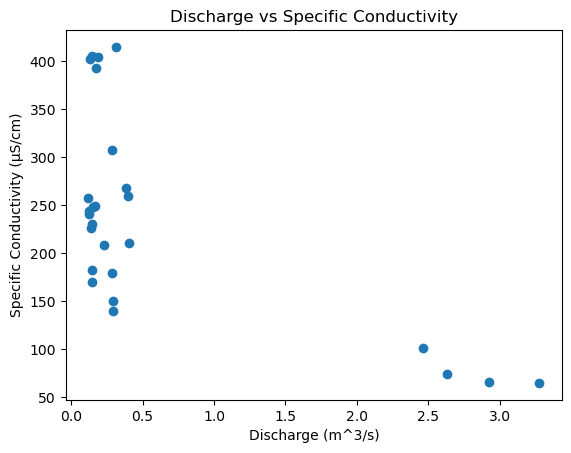

In [38]:
plt.scatter(new_dataframe['watershed boundary discharge [m3 s^-1]'], new_dataframe['p00095'])

plt.xlabel('Discharge (m^3/s)')
plt.ylabel('Specific Conductivity (µS/cm)')
plt.title('Discharge vs Specific Conductivity')
plt.grid(False)

plt.show()

In [39]:
sc_count = new_dataframe['p00095'].count()
print(f"Number of valid SC observations: {sc_count}")

Number of valid SC observations: 26


### Interpolation of SC using power function with discharge obtained from ATS numerical model:

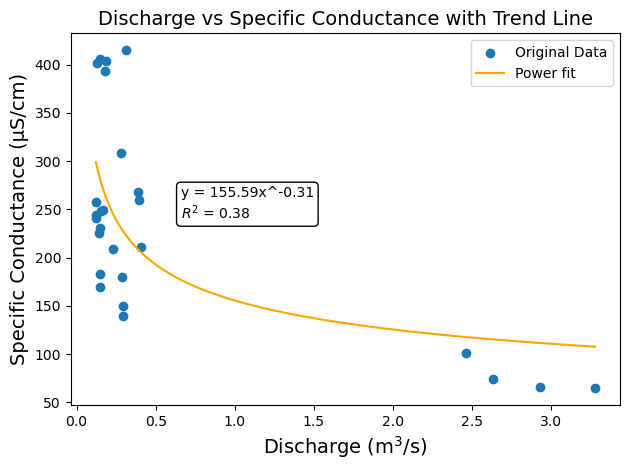

(None, array([155.58556818,  -0.3094204 ]), np.float64(0.381067732323045))

In [40]:
cleaned_df_250 = new_dataframe.dropna(subset=['watershed boundary discharge [m3 s^-1]', 'p00095'])

x_cleaned = cleaned_df_250['watershed boundary discharge [m3 s^-1]'].values
y_cleaned = cleaned_df_250['p00095'].values

def power_func(x, a, b):
    return a * np.power(x, b)

# Curve fitting with cleaned data
popt_cleaned, pcov_cleaned = curve_fit(power_func, x_cleaned, y_cleaned)

# Generating values for the trend line with cleaned data
x_fit_cleaned = np.linspace(x_cleaned.min(), x_cleaned.max(), 100)
y_fit_cleaned = power_func(x_fit_cleaned, *popt_cleaned)

# Calculate R-squared with cleaned data
residuals_cleaned = y_cleaned - power_func(x_cleaned, *popt_cleaned)
ss_res_cleaned = np.sum(residuals_cleaned**2)
ss_tot_cleaned = np.sum((y_cleaned - np.mean(y_cleaned))**2)
r_squared_cleaned = 1 - (ss_res_cleaned / ss_tot_cleaned)

# Plotting with cleaned data
plt.scatter(x_cleaned, y_cleaned, label='Original Data')
plt.plot(x_fit_cleaned, y_fit_cleaned, color='orange', label='Power fit')

plt.xlabel(r'Discharge (m$^3$/s)', fontsize = fontsize)
plt.ylabel('Specific Conductance (µS/cm)', fontsize = fontsize)
plt.title('Discharge vs Specific Conductance with Trend Line', fontsize = fontsize)

plt.grid(False)

# Annotating with the power function equation and R^2 with cleaned data
equation_text_cleaned = f'y = {popt_cleaned[0]:.2f}x^{popt_cleaned[1]:.2f}\n$R^2$ = {r_squared_cleaned:.2f}'
plt.annotate(equation_text_cleaned, xy=(0.2, 0.50), xycoords='axes fraction', 
             bbox=dict(boxstyle="round", fc="w"))

plt.legend()
plt.tight_layout()
plt.savefig('figures/discharge_SC_relationship_new.png', dpi=500)
plt.show(), popt_cleaned, r_squared_cleaned


In [41]:
interpolated_SC = power_func(merged_df['watershed boundary discharge [m3 s^-1]'].values, *popt_cleaned)
merged_df['interpolated_SC_power'] = interpolated_SC

### Calulating runoff and baseflow end members:

In [42]:
#### Runoff end member calculations: the average of the SC measured in May and June
snowmelt_period = new_dataframe[(new_dataframe.index.month == 5) | (new_dataframe.index.month == 6)]
ro_end_member = snowmelt_period['p00095'].mean()
ro_end_member

np.float64(76.5)

In [43]:
#### Baseflow end member calculation: Calculate SCbf as the 99th percentile of all the interpolated specific conductance data
bf_end_member = merged_df['interpolated_SC_power'].quantile(0.99)
bf_end_member

np.float64(305.68971322570883)

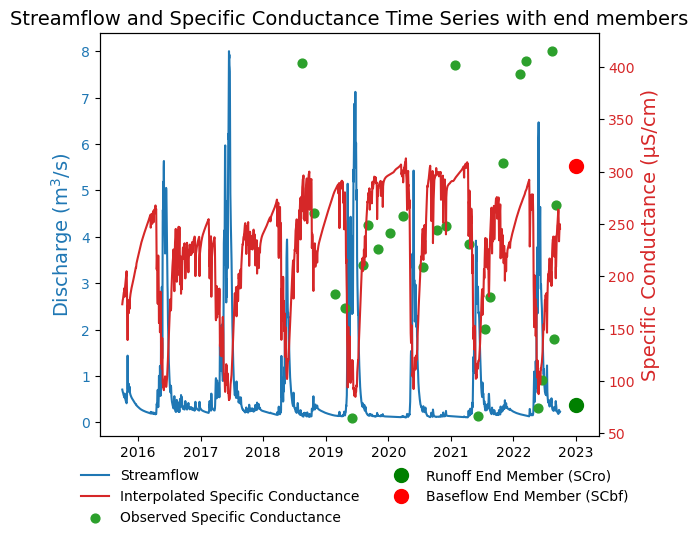

In [44]:
fig, ax1 = plt.subplots()



ax1.set_ylabel(r'Discharge (m$^3$/s)', color='tab:blue', fontsize = fontsize)
ax1.plot(merged_df.index, merged_df['watershed boundary discharge [m3 s^-1]'], label='Streamflow', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')


ax2 = ax1.twinx()


ax2.set_ylabel('Specific Conductance (µS/cm)', color='tab:red', fontsize = fontsize)
ax2.plot(merged_df.index, merged_df['interpolated_SC_power'], linestyle='-', label='Interpolated Specific Conductance', color='tab:red')
ax2.scatter(cleaned_df_250.index, cleaned_df_250['p00095'], color='tab:green', label='Observed Specific Conductance', marker='o', s=40)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot the new end members (Runoff and Baseflow)
ax2.plot(pd.to_datetime('2023-01-01'), ro_end_member, 'go', markersize=10, label='Runoff End Member (SCro)')
ax2.plot(pd.to_datetime('2023-01-01'), bf_end_member, 'ro', markersize=10, label='Baseflow End Member (SCbf)')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines + lines2,
    labels + labels2,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.13),
    ncol=2,
    frameon=False
)
plt.title('Streamflow and Specific Conductance Time Series with end members', fontsize = fontsize)

plt.tight_layout()

plt.savefig('figures/interpolated_SC.png', dpi=500, bbox_inches='tight')


plt.show()


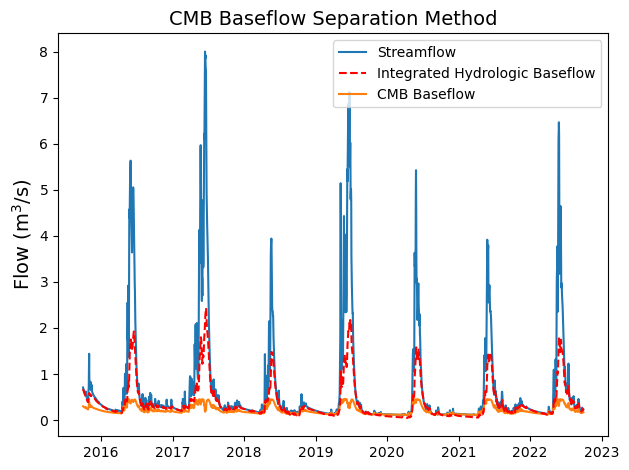

In [45]:
merged_df['MCB_baseflow_power'] = merged_df['watershed boundary discharge [m3 s^-1]'] * ((merged_df['interpolated_SC_power'] - ro_end_member) / (bf_end_member - ro_end_member))

fig, ax = plt.subplots()

# Plot total discharge
ax.plot(merged_df.index, merged_df['watershed boundary discharge [m3 s^-1]'], label='Streamflow')


# Plot MCB_baseflow
ax.plot(df.index , df['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--', zorder=10)
ax.plot(merged_df.index, merged_df['MCB_baseflow_power'], label='CMB Baseflow')


ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)
ax.legend()


plt.title('CMB Baseflow Separation Method', fontsize = fontsize)
plt.tight_layout()
plt.savefig('figures/CMB_baseflow.png', dpi=500)
plt.show()

In [46]:
startdate = '2016-04-01'
enddate = '2016-09-01'
filtereddf = df[(df.index >= startdate) & (df.index <= enddate)]


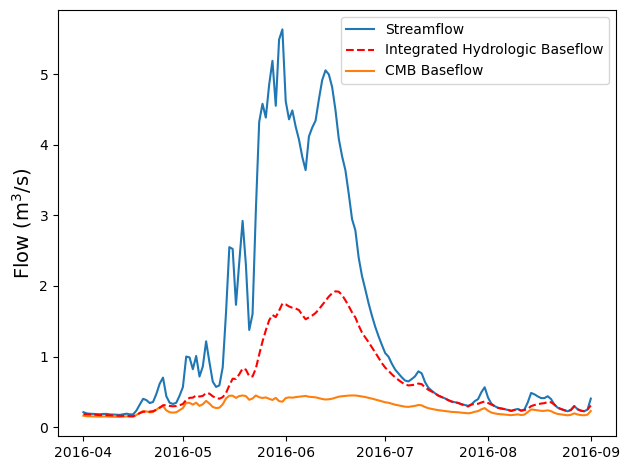

In [47]:
start_date = '2016-04-01'
end_date = '2016-09-01'
merged_df_zoom = merged_df.loc[start_date:end_date]

fig, ax = plt.subplots()

# Plot total discharge
ax.plot(merged_df_zoom.index, merged_df_zoom['watershed boundary discharge [m3 s^-1]'], label='Streamflow')

# Plot MCB_baseflow
ax.plot(filtereddf.index , filtereddf['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--', zorder=10)
ax.plot(merged_df_zoom.index, merged_df_zoom['MCB_baseflow_power'], label='CMB Baseflow')



ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)
ax.legend()
plt.tight_layout()
plt.tight_layout()
plt.savefig('figures/zoom_CMB_baseflow.png', dpi=800)
plt.show()

In [48]:
start_date = '2016-10-01'
end_date = '2017-10-01'
merged_df_2017 = merged_df.loc[start_date:end_date]

max_baseflow_value = merged_df_2017['MCB_baseflow_power'].max()
max_baseflow_date = merged_df_2017['MCB_baseflow_power'].idxmax()

max_streamflow_value = merged_df_2017['watershed boundary discharge [m3 s^-1]'].max()
max_streamflow_date = merged_df_2017['watershed boundary discharge [m3 s^-1]'].idxmax()

print(f"Highest baseflow (2017): {max_baseflow_value} m³/s on {max_baseflow_date}")
print(f"Highest streamflow (2017): {max_streamflow_value} m³/s on {max_streamflow_date}")

Highest baseflow (2017): 0.44814410878620936 m³/s on 2017-05-31 00:00:00
Highest streamflow (2017): 8.002212708047631 m³/s on 2017-06-15 00:00:00


In [49]:
start_date = '2020-10-01'
end_date = '2021-10-01'
merged_df_2021 = merged_df.loc[start_date:end_date]

max_baseflow_value = merged_df_2021['MCB_baseflow_power'].max()
max_baseflow_date = merged_df_2021['MCB_baseflow_power'].idxmax()

max_streamflow_value = merged_df_2021['watershed boundary discharge [m3 s^-1]'].max()
max_streamflow_date = merged_df_2021['watershed boundary discharge [m3 s^-1]'].idxmax()

print(f"Highest baseflow (2021): {max_baseflow_value} m³/s on {max_baseflow_date}")
print(f"Highest streamflow (2021): {max_streamflow_value} m³/s on {max_streamflow_date}")

Highest baseflow (2021): 0.44821437134634257 m³/s on 2021-06-07 00:00:00
Highest streamflow (2021): 3.916489722003254 m³/s on 2021-05-27 00:00:00


### Sensitivity test to find the impact of end members on the baseflow by changing end members by +-10%

In [50]:
# RO end members ±10%
ro_end_member_plus_10per = ro_end_member + (ro_end_member * 10 / 100)
ro_plus_value = int(round(ro_end_member_plus_10per))
col_ro_plus = f'MCB_baseflow_power_{ro_plus_value}'

ro_end_member_minus_10per = ro_end_member - (ro_end_member * 10 / 100)
ro_minus_value = int(round(ro_end_member_minus_10per))
col_ro_minus = f'MCB_baseflow_power_{ro_minus_value}'

# BF end members ±10%
bf_end_member_plus_10per = bf_end_member + (bf_end_member * 10 / 100)
bf_plus_value = int(round(bf_end_member_plus_10per))
col_bf_plus = f'MCB_baseflow_power_{bf_plus_value}'

bf_end_member_minus_10per = bf_end_member - (bf_end_member * 10 / 100)
bf_minus_value = int(round(bf_end_member_minus_10per))
col_bf_minus = f'MCB_baseflow_power_{bf_minus_value}'

In [51]:
# RO variations
merged_df[col_ro_plus] = merged_df['watershed boundary discharge [m3 s^-1]'] * (
    (merged_df['interpolated_SC_power'] - ro_end_member_plus_10per) / (bf_end_member - ro_end_member_plus_10per)
)

merged_df[col_ro_minus] = merged_df['watershed boundary discharge [m3 s^-1]'] * (
    (merged_df['interpolated_SC_power'] - ro_end_member_minus_10per) / (bf_end_member - ro_end_member_minus_10per)
)

# BF variations
merged_df[col_bf_plus] = merged_df['watershed boundary discharge [m3 s^-1]'] * (
    (merged_df['interpolated_SC_power'] - ro_end_member) / (bf_end_member_plus_10per - ro_end_member)
)

merged_df[col_bf_minus] = merged_df['watershed boundary discharge [m3 s^-1]'] * (
    (merged_df['interpolated_SC_power'] - ro_end_member) / (bf_end_member_minus_10per - ro_end_member)
)

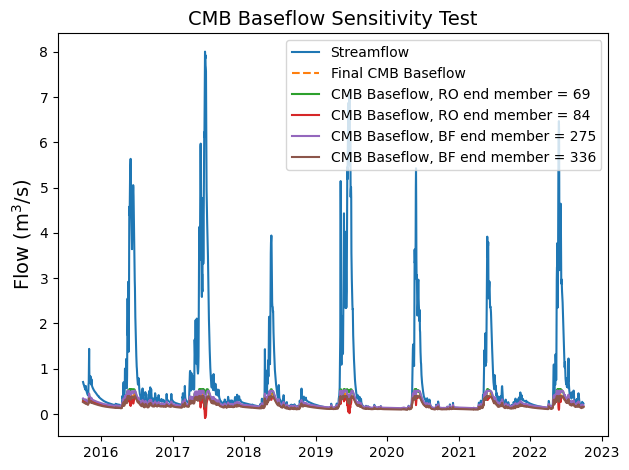

In [52]:
fig, ax = plt.subplots()


ax.plot(merged_df.index, merged_df['watershed boundary discharge [m3 s^-1]'], label='Streamflow')
ax.plot(merged_df.index, merged_df['MCB_baseflow_power'], label='Final CMB Baseflow', linestyle='--')


ax.plot(merged_df.index, merged_df[col_ro_minus], label=f'CMB Baseflow, RO end member = {ro_minus_value}')
ax.plot(merged_df.index, merged_df[col_ro_plus],  label=f'CMB Baseflow, RO end member = {ro_plus_value}')
ax.plot(merged_df.index, merged_df[col_bf_minus], label=f'CMB Baseflow, BF end member = {bf_minus_value}')
ax.plot(merged_df.index, merged_df[col_bf_plus],  label=f'CMB Baseflow, BF end member = {bf_plus_value}')

ax.set_ylabel(r'Flow (m$^3$/s)', fontsize=fontsize)
ax.legend()
plt.title('CMB Baseflow Sensitivity Test', fontsize=fontsize)
plt.tight_layout()
plt.savefig('figures/sensitivity_test_CMB.png', dpi=500)
plt.show()

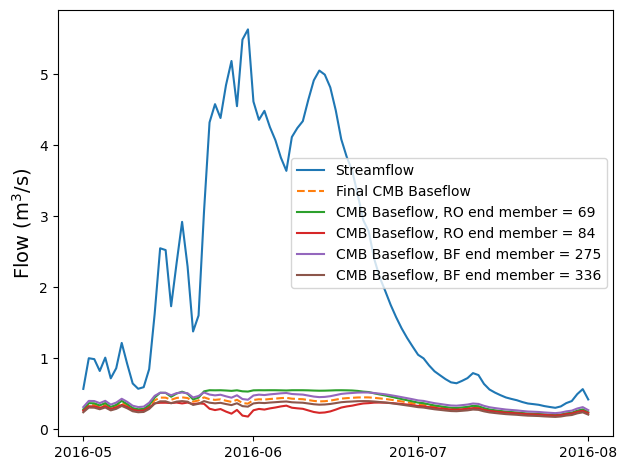

In [53]:
start_date = '2016-05-01'
end_date = '2016-08-01'
merged_df_zoom_test = merged_df.loc[start_date:end_date]

fig, ax = plt.subplots()

# Plot total discharge
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test['watershed boundary discharge [m3 s^-1]'], label='Streamflow')

# Plot MCB baseflow variants
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test['MCB_baseflow_power'], label='Final CMB Baseflow', linestyle='--')

# Use dynamic columns and labels
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test[col_ro_minus], label=f'CMB Baseflow, RO end member = {ro_minus_value}')
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test[col_ro_plus],  label=f'CMB Baseflow, RO end member = {ro_plus_value}')
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test[col_bf_minus], label=f'CMB Baseflow, BF end member = {bf_minus_value}')
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test[col_bf_plus],  label=f'CMB Baseflow, BF end member = {bf_plus_value}')

# Format
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize=fontsize)
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.savefig('figures/sensitivity_test_CMB_zoom.png', dpi=500)
plt.show()


#### "The 'MCB_baseflow_power_84' baseflow shows a decline in 2017 that may reach negative values. To assess this, we examine whether any daily estimated baseflow values fall below zero."

In [54]:

negatives = {}

for col, label in zip(
    [col_ro_plus, col_ro_minus, col_bf_plus, col_bf_minus],
    [f'RO+10% = {ro_plus_value}', f'RO-10% = {ro_minus_value}',
     f'BF+10% = {bf_plus_value}', f'BF-10% = {bf_minus_value}']
):
    has_neg = (merged_df[col] < 0).any()
    neg_count = (merged_df[col] < 0).sum()
    neg_rows = merged_df[merged_df[col] < 0]

    # Store results
    negatives[col] = {
        "label": label,
        "has_negative": has_neg,
        "count": neg_count,
        "rows": neg_rows
    }


In [55]:
for col, info in negatives.items():
    print(f"Column: {col} ({info['label']})")
    print(f"  Has negative values? {info['has_negative']}")
    print(f"  Count of negative values: {info['count']}")
    print()

Column: MCB_baseflow_power_84 (RO+10% = 84)
  Has negative values? True
  Count of negative values: 7

Column: MCB_baseflow_power_69 (RO-10% = 69)
  Has negative values? False
  Count of negative values: 0

Column: MCB_baseflow_power_336 (BF+10% = 336)
  Has negative values? False
  Count of negative values: 0

Column: MCB_baseflow_power_275 (BF-10% = 275)
  Has negative values? False
  Count of negative values: 0



In [56]:
negative_days_ro_plus = merged_df[merged_df[col_ro_plus] < 0].index
negative_days_ro_plus

DatetimeIndex(['2017-06-14', '2017-06-15', '2017-06-16', '2017-06-17',
               '2017-06-18', '2017-06-19', '2017-06-20'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [57]:
negative_values_ro_plus = merged_df.loc[merged_df[col_ro_plus] < 0, col_ro_plus]
print(negative_values_ro_plus)

datetime
2017-06-14   -0.056216
2017-06-15   -0.086623
2017-06-16   -0.067526
2017-06-17   -0.077245
2017-06-18   -0.048879
2017-06-19   -0.042930
2017-06-20   -0.032754
Name: MCB_baseflow_power_84, dtype: float64


# (3) Digital Filter Method

## Calculating the recession constant using recession analysis:

In [58]:
df_digital=df

df_digital['decreasing_gw'] = df_digital['GW_discharge_new_dryperiod [m d^-1]'].diff().lt(0).astype(int)
df_digital['not_nan'] = df_digital['GW_discharge_new_dryperiod [m d^-1]'].notna().astype(int)
df_digital['decreasing_gw'] = df_digital['decreasing_gw'] * df_digital['not_nan']
df_digital['decreasing_gw_streak'] = df_digital['decreasing_gw'] * (df_digital['decreasing_gw'].groupby((df_digital['decreasing_gw'] != df_digital['decreasing_gw'].shift()).cumsum()).cumcount() + 1)



five_day_decrease_gw_periods = df_digital[df_digital['decreasing_gw_streak'] >= 5]
five_day_decrease_gw_periods['Qt'] = five_day_decrease_gw_periods['GW_discharge_new_dryperiod [m d^-1]']
five_day_decrease_gw_periods['Qt_plus_1'] = five_day_decrease_gw_periods['Qt'].shift(-1)
filtered_gw_df = five_day_decrease_gw_periods.dropna(subset=['Qt', 'Qt_plus_1'])

C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\3543297436.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_day_decrease_gw_periods['Qt'] = five_day_decrease_gw_periods['GW_discharge_new_dryperiod [m d^-1]']
C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\3543297436.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_day_decrease_gw_periods['Qt_plus_1'] = five_day_decrease_gw_periods['Qt'].shift(-1)


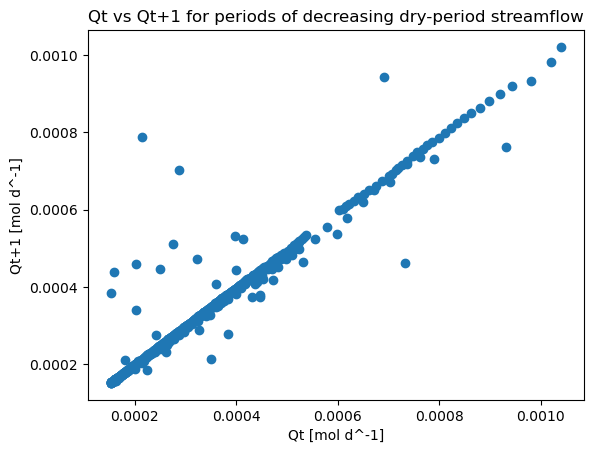

In [59]:
plt.scatter(filtered_gw_df['Qt'], filtered_gw_df['Qt_plus_1'])
plt.xlabel('Qt [mol d^-1]')
plt.ylabel('Qt+1 [mol d^-1]')
plt.title('Qt vs Qt+1 for periods of decreasing dry-period streamflow')
plt.savefig('figures/recession analysis', dpi=500)
plt.show()

In [60]:
X_gw = filtered_gw_df['Qt'].values.reshape(-1, 1)
y_gw = filtered_gw_df['Qt_plus_1'].values

reg_gw = LinearRegression(fit_intercept=False)
reg_gw.fit(X_gw, y_gw)
recession_constant_a_gw = reg_gw.coef_[0]
print(f"recession constant: {recession_constant_a_gw}")

recession constant: 0.9881641114040819


## Calculating BFImax using LH method:

In [61]:
df_BFI = df_digital
df_BFI['watershed boundary discharge [m^3/s]'] = df_BFI['watershed boundary discharge [m^3/d]'] / 86400
series = df_BFI['watershed boundary discharge [m^3/s]']

if not isinstance(series.index, pd.DatetimeIndex):
    series.index = pd.to_datetime(series.index)

Q, date = clean_streamflow(series)

a=recession_constant_a_gw


b_LH = LH(Q)


BFImax = param_calibrate(np.arange(0.001, 1, 0.001), Eckhardt, Q, b_LH, a)

print(f"BFImax: {BFImax}")

BFImax: 0.763


## Calculating and plotting digital filter method baseflow using a 'multi-method baseflow separation function'

In [62]:
xie_baseflow=df

In [63]:
def clean_streamflow(series):
    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a pandas Series")
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Series index must be a DateTimeIndex")

    date = series.index
    Q = series.values.astype(float)


    has_value = np.isfinite(Q)
    date = date[has_value]
    Q = np.abs(Q[has_value])

    water_years = np.where(date.month >= 10, date.year + 1, date.year)

    wy_unique, wy_counts = np.unique(water_years, return_counts=True)

    valid_wy = wy_unique[wy_counts >= 120]

    keep = np.isin(water_years, valid_wy)

    return Q[keep], date[keep]

    a=recession_constant_a_gw
BFImax=BFImax
area=20.4
ice = None
BFImax

0.763

In [64]:
def single(series, area=area, ice=None, method='all', return_kge=True):
    Q, date = clean_streamflow(series)
    method = format_method(method)

    b_LH = LH(Q)
    b = pd.DataFrame(np.nan, index=date, columns=method)
    for m in method:
        if m == 'UKIH':
            b[m] = UKIH(Q, b_LH)

        if m == 'Local':
            b[m] = Local(Q, b_LH, area)

        if m == 'Fixed':
            b[m] = Fixed(Q, area)

        if m == 'Slide':
            b[m] = Slide(Q, area)

        if m == 'LH':
            b[m] = b_LH



        if m == 'Eckhardt':
            # BFImax = maxmium_BFI(Q, b_LH, a, date)
            # BFImax = param_calibrate(np.arange(0.001, 1, 0.001), Eckhardt, Q, b_LH, a)
            b[m] = Eckhardt(Q, b_LH, a, BFImax)


    return b, None
series = xie_baseflow['watershed boundary discharge [m^3/s]']
b, _ = single(series, area=area, ice=ice, method='all', return_kge=False)

b = b[b.index >= '2015-10-01']

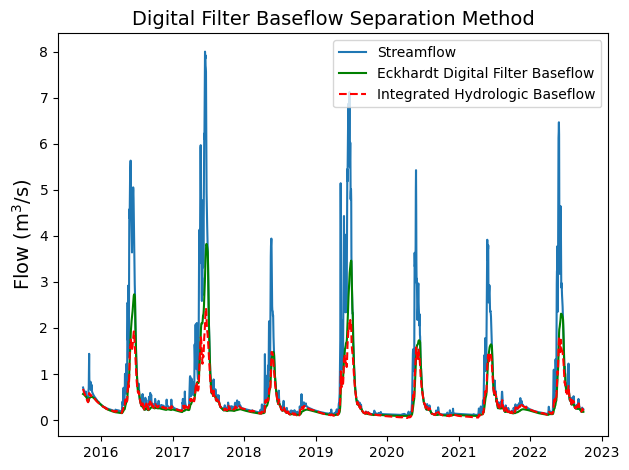

In [65]:
plt.figure()  

plt.plot(xie_baseflow.index, xie_baseflow['watershed boundary discharge [m^3/s]'], label='Streamflow')
plt.plot(b.index, b['Eckhardt'], label='Eckhardt Digital Filter Baseflow', color='green')
plt.plot(df.index , df['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--')

plt.legend()
plt.title('Digital Filter Baseflow Separation Method', fontsize = fontsize)
plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)

plt.tight_layout()

plt.savefig('figures/Digital Filter Baseflow Separation Method', dpi=500)
plt.show()

In [66]:
startdate = '2016-04-01'
enddate = '2016-09-01'
filtered_xie_baseflow = xie_baseflow[(xie_baseflow.index >= startdate) & (xie_baseflow.index <= enddate)]
filtered_b = b[(b.index >= startdate) & (b.index <= enddate)]
filtered_df = df[(df.index >= startdate) & (df.index <= enddate)]

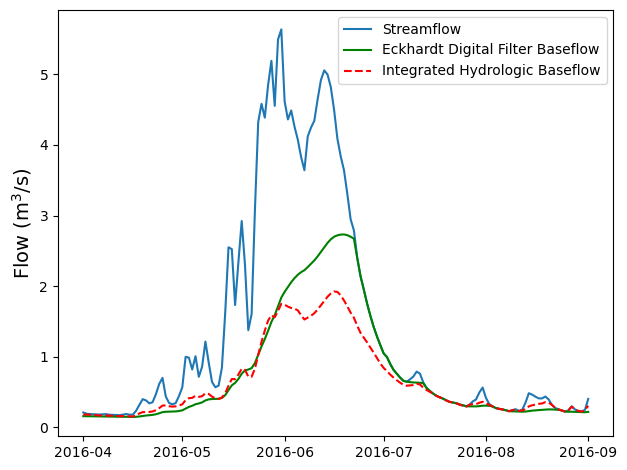

In [67]:
plt.figure()  

plt.plot(filtered_xie_baseflow.index, filtered_xie_baseflow['watershed boundary discharge [m^3/s]'], label='Streamflow')
plt.plot(filtered_b.index, filtered_b['Eckhardt'], label='Eckhardt Digital Filter Baseflow', color='green')
plt.plot(filtered_df.index , filtered_df['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--')

plt.legend()
plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)

plt.tight_layout()

plt.savefig('figures/Digital Filter Baseflow Separation Method_2016', dpi=500)
plt.show()

# Sensitivity test of Digital Filter Method: 
#### The sensitivity test for the digital filter method is applied for different BFImax values (+-10% of BFImax) using the "multi-method baseflow separation function".

#### Find the baseflow when BFImax=0.663

In [68]:
def clean_streamflow(series):
    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a pandas Series")
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Series index must be a DateTimeIndex")

    date = series.index
    Q = series.values.astype(float)

    has_value = np.isfinite(Q)
    date = date[has_value]
    Q = np.abs(Q[has_value])

    # Water year: Oct–Sep belongs to the NEXT calendar year 
    water_years = np.where(date.month >= 10, date.year + 1, date.year)

    # Count valid entries per water year and keep WYs with at least 120 days
    wy_unique, wy_counts = np.unique(water_years, return_counts=True)
    valid_wy = wy_unique[wy_counts >= 120]

    keep = np.isin(water_years, valid_wy)

    return Q[keep], date[keep]



a = recession_constant_a_gw
BFImax_6 = 0.663
area = 20.4
ice = None

In [69]:
def single(series, area=area, ice=None, method='all', return_kge=False):
    Q, date = clean_streamflow(series)
    method = format_method(method)

    b_LH = LH(Q)
    b6 = pd.DataFrame(np.nan, index=date, columns=method)
    for m in method:
        if m == 'UKIH':
            b6[m] = UKIH(Q, b_LH)
        if m == 'Local':
            b6[m] = Local(Q, b_LH, area)
        if m == 'Fixed':
            b6[m] = Fixed(Q, area)
        if m == 'Slide':
            b6[m] = Slide(Q, area)
        if m == 'LH':
            b6[m] = b_LH
        if m == 'Eckhardt':
            b6[m] = Eckhardt(Q, b_LH, a, BFImax_6)

    return b6, None

series = xie_baseflow['watershed boundary discharge [m^3/s]']
b6, _ = single(series, area=area, ice=ice, method='all', return_kge=False)


#### Find the baseflow when BFImax = 0.863

In [70]:
a = recession_constant_a_gw
BFImax_8 = 0.863
area = 20.4
ice = None

def clean_streamflow(series):
    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a pandas Series")
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Series index must be a DateTimeIndex")

    date = series.index
    Q = series.values.astype(float)


    has_value = np.isfinite(Q)
    date = date[has_value]
    Q = np.abs(Q[has_value])

    # Water year: Oct–Sep belongs to the NEXT calendar year
    water_years = np.where(date.month >= 10, date.year + 1, date.year)

    # Count valid entries per water year and keep WYs with at least 120 days
    wy_unique, wy_counts = np.unique(water_years, return_counts=True)
    valid_wy = wy_unique[wy_counts >= 120]

    keep = np.isin(water_years, valid_wy)

    return Q[keep], date[keep]

In [71]:
def single(series, area=area, ice=None, method='all', return_kge=False):
    Q, date = clean_streamflow(series)
    method = format_method(method)

    b_LH = LH(Q)
    b8 = pd.DataFrame(np.nan, index=date, columns=method)
    for m in method:
        if m == 'UKIH':
            b8[m] = UKIH(Q, b_LH)
        if m == 'Local':
            b8[m] = Local(Q, b_LH, area)
        if m == 'Fixed':
            b8[m] = Fixed(Q, area)
        if m == 'Slide':
            b8[m] = Slide(Q, area)
        if m == 'LH':
            b8[m] = b_LH
        if m == 'Eckhardt':
            b8[m] = Eckhardt(Q, b_LH, a, BFImax_8)

    return b8, None

series = xie_baseflow['watershed boundary discharge [m^3/s]']
b8, _ = single(series, area=area, ice=ice, method='all', return_kge=False)


b8 = b8[b8.index >= '2015-10-01']

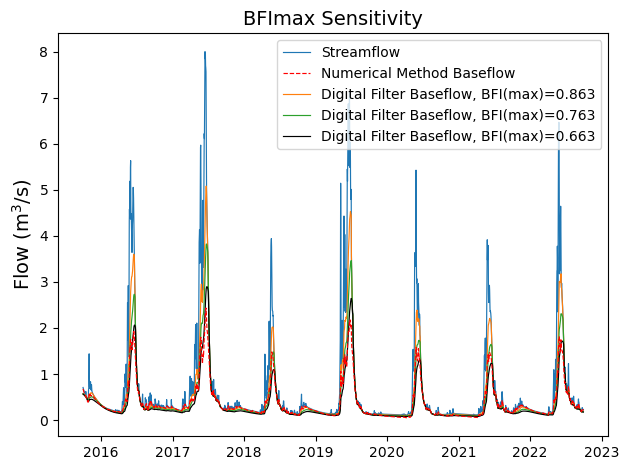

In [72]:
plt.figure()  

plt.plot(xie_baseflow.index, xie_baseflow['watershed boundary discharge [m^3/s]'], label='Streamflow', linewidth=0.85)
plt.plot(df.index , df['final_baseflow [m3 s^-1]'], label='Numerical Method Baseflow',color = 'red', linewidth=0.85, linestyle='--', zorder=10)

plt.plot(b8.index, b8['Eckhardt'], label='Digital Filter Baseflow, BFI(max)=0.863', linewidth=0.85)
plt.plot(b.index, b['Eckhardt'], label='Digital Filter Baseflow, BFI(max)=0.763', linewidth=0.85)
plt.plot(b6.index, b6['Eckhardt'], label='Digital Filter Baseflow, BFI(max)=0.663', linewidth=0.85, color='black')


plt.legend()
plt.title('BFImax Sensitivity', fontsize = fontsize)
plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)
plt.tight_layout()
plt.savefig('figures/BFImax_sensitivity', dpi=500)
plt.show()

In [73]:
# Ensure datetime indexes
for _obj in [xie_baseflow, df, b8, b, b6]:
    if not isinstance(_obj.index, pd.DatetimeIndex):
        _obj.index = pd.to_datetime(_obj.index)

# compute yearly BFI (%) on water year ending Sep
def yearly_bfi_stats(baseflow_series, streamflow_series):
    aligned = pd.concat(
        [baseflow_series.rename('baseflow'),
         streamflow_series.rename('streamflow')],
        axis=1, join='inner'
    )

    bf_y = aligned['baseflow'].resample('YE-SEP').sum(min_count=1)
    sf_y = aligned['streamflow'].resample('YE-SEP').sum(min_count=1)

    bfi_y = (bf_y / sf_y) * 100
    return bfi_y, bfi_y.mean(), bfi_y.std()

# Compute for the three Eckhardt runs
bfi_b8,  mean_b8,  std_b8  = yearly_bfi_stats(b8['Eckhardt'], xie_baseflow['watershed boundary discharge [m^3/s]'])
bfi_b,   mean_b,   std_b   = yearly_bfi_stats(b['Eckhardt'],  xie_baseflow['watershed boundary discharge [m^3/s]'])
bfi_b6,  mean_b6,  std_b6  = yearly_bfi_stats(b6['Eckhardt'], xie_baseflow['watershed boundary discharge [m^3/s]'])

# Assemble results table
bfi_tbl = pd.DataFrame({
    'BFI BFImax=0.863': bfi_b8,
    'BFI BFImax=0.763': bfi_b,
    'BFI BFImax=0.663': bfi_b6
})

# Make the index just the water year (e.g., '2016')
bfi_tbl.index = bfi_tbl.index.year.astype(str)

# Add summary rows
bfi_tbl.loc['Mean (%)'] = [mean_b8, mean_b, mean_b6]
bfi_tbl.loc['Std (%)']  = [std_b8,  std_b,  std_b6]

bfi_tbl


,BFI BFImax=0.863,BFI BFImax=0.763,BFI BFImax=0.663
datetime,,,
2016,75.604260,63.913978,55.107633
2017,73.255257,61.861110,51.326348
2018,75.812600,64.580180,55.788528
2019,72.731370,59.414844,48.897801
2020,73.192794,60.686655,50.857011
2021,73.896100,61.194122,51.479898
2022,74.315253,62.339625,52.711636
Mean (%),74.115376,61.998645,52.309837
Std (%),1.203593,1.803359,2.432390


In [74]:
startdate = '2016-05-01'
enddate = '2016-10-01'
filtered_xie_baseflow  = xie_baseflow.loc[startdate:enddate]
b8  = b8.loc[startdate:enddate]
b6  = b6.loc[startdate:enddate]
b_org  = b.loc[startdate:enddate]
filt_combined_df=df.loc[startdate:enddate]

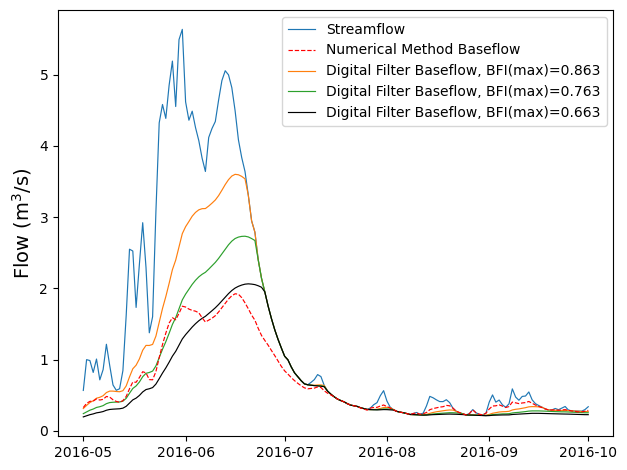

In [75]:
plt.figure()  

plt.plot(filtered_xie_baseflow.index, filtered_xie_baseflow['watershed boundary discharge [m^3/s]'], label='Streamflow', linewidth=0.85)
plt.plot(filt_combined_df.index, filt_combined_df['final_baseflow [m3 s^-1]'], label='Numerical Method Baseflow',color = 'red', linewidth=0.85, linestyle='--', zorder=10)

plt.plot(b8.index, b8['Eckhardt'], label='Digital Filter Baseflow, BFI(max)=0.863', linewidth=0.85)
plt.plot(b_org.index, b_org['Eckhardt'], label='Digital Filter Baseflow, BFI(max)=0.763', linewidth=0.85)
plt.plot(b6.index, b6['Eckhardt'], label='Digital Filter Baseflow, BFI(max)=0.663', linewidth=0.85, color='black')


plt.legend()
plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)
plt.tight_layout()
plt.savefig('figures/BFI_max Sensitivity Test', dpi=500)
plt.show()

## (4) UKIH method

#### To calculate the baseflow for UKIH, we used 'baseflow.separation' function. In the cell bellow, we added extra dummy data before 2015 to make sure the function works well and separate the baseflow without errors. Our correct data starts from Sep 01, 2015, and it will not be affected. 

In [76]:
UKIH_streamflow=df
UKIH_streamflow = UKIH_streamflow[['watershed boundary discharge [m^3/s]']]

col = 'watershed boundary discharge [m^3/s]'

# Define padding period
real_start = UKIH_streamflow.index.min()
pad_start = pd.Timestamp('2014-12-31')
pad_end = real_start - pd.Timedelta(days=1)

pad_index = pd.date_range(start=pad_start, end=pad_end, freq='D')

# Choose flow value and ramping
ramp_days = 7
flat_days = len(pad_index) - ramp_days

# Set all dummy values around 0.5
flat_part = np.full(flat_days, 0.5)

# Ramp up from 0.5 to real flow on 2015-10-01
real_val = UKIH_streamflow.loc[real_start, col]
ramp_part = np.linspace(0.5, real_val, ramp_days)

# Combine both
dummy_values = np.concatenate([flat_part, ramp_part])
dummy_streamflow = pd.DataFrame({col: dummy_values}, index=pad_index)

# Combine dummy + real streamflow
padded_streamflow = pd.concat([dummy_streamflow, UKIH_streamflow])
padded_streamflow = padded_streamflow.sort_index()

# Run separation
UKIH_sep_full = baseflow.separation(padded_streamflow)


100%|██████████| 1/1 [00:34<00:00, 34.17s/it]


In [77]:

bf_ukih = UKIH_sep_full['UKIH']
bf_ukih = bf_ukih[bf_ukih.index >= '2015-10-01']

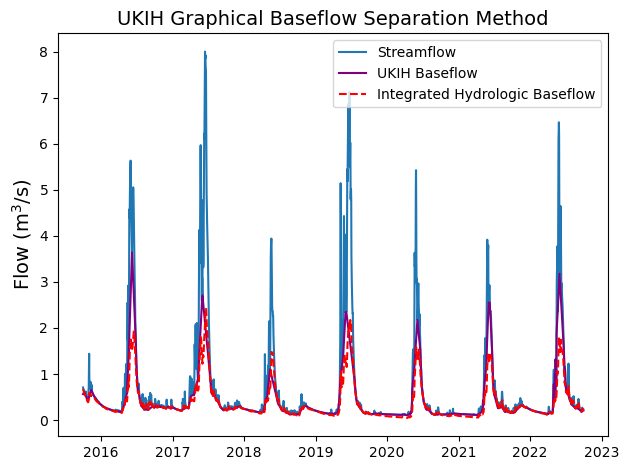

In [78]:
plt.figure()

plt.plot(UKIH_streamflow.index, UKIH_streamflow['watershed boundary discharge [m^3/s]'], label='Streamflow')
plt.plot(bf_ukih.index, bf_ukih['watershed boundary discharge [m^3/s]'], label='UKIH Baseflow', color='purple')
plt.plot(df.index , df['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--')

# Adding labels and title
plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)
plt.title('UKIH Graphical Baseflow Separation Method', fontsize = fontsize)
plt.tight_layout()
# Adding legend
plt.legend()
plt.savefig('figures/UKIH Graphical Baseflow Separation Method.png', dpi = 500)
plt.show()

In [79]:
startdate = '2016-04-01'
enddate = '2016-09-01'
filtered_UKIH_streamflow = UKIH_streamflow[(UKIH_streamflow.index >= startdate) & (UKIH_streamflow.index <= enddate)]
filtered_bf_ukih = bf_ukih[(bf_ukih.index >= startdate) & (bf_ukih.index <= enddate)]

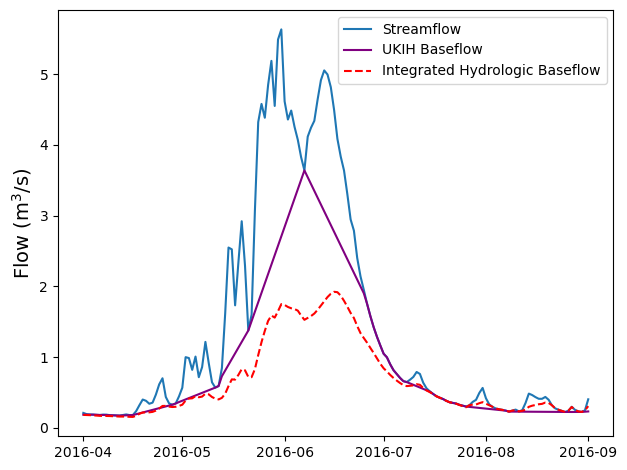

In [80]:
plt.figure()

plt.plot(filtered_UKIH_streamflow.index, filtered_UKIH_streamflow['watershed boundary discharge [m^3/s]'], label='Streamflow')
plt.plot(filtered_bf_ukih.index, filtered_bf_ukih['watershed boundary discharge [m^3/s]'], label='UKIH Baseflow', color= 'purple')
plt.plot(filtereddf.index , filtereddf['final_baseflow [m3 s^-1]'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--')


# Adding labels and title
plt.ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)
# plt.title('UKIH Graphical Baseflow Separation Method', fontsize = fontsize)
plt.tight_layout()
# Adding legend
plt.legend()
plt.savefig('figures/UKIH Graphical Baseflow Separation Method_zoom.png', dpi = 500)
plt.show()

#### Plotting turning points

In [81]:
# Extract baseflow series
bf_series = filtered_bf_ukih['watershed boundary discharge [m^3/s]']
bf_index = filtered_bf_ukih.index

# Compute slope between points
slope = np.diff(bf_series)

# Define a slope change threshold
threshold = 0.001 

# Detect slope change above threshold
slope_diff = np.diff(slope)
significant_change = np.abs(slope_diff) > threshold

# Get indices where slope changes significantly
turning_idx = np.where(significant_change)[0] + 1  # +1 for correct index shift

# Extract dates and values of turning points
turning_dates = bf_index[turning_idx]
turning_values = bf_series.iloc[turning_idx]


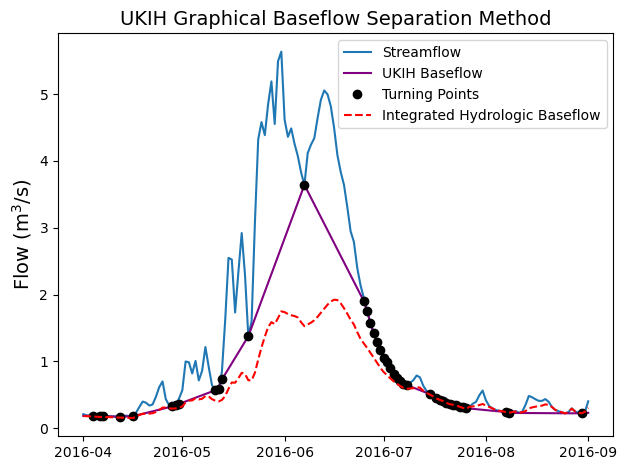

In [82]:
plt.figure()

# Streamflow
plt.plot(filtered_UKIH_streamflow.index,
         filtered_UKIH_streamflow['watershed boundary discharge [m^3/s]'],
         label='Streamflow')

# UKIH baseflow line
plt.plot(bf_index, bf_series, label='UKIH Baseflow', color='purple')

# Turning point markers only
plt.plot(turning_dates, turning_values, 'ko', markersize=6, label='Turning Points')


plt.plot(filtereddf.index,
         filtereddf['final_baseflow [m3 s^-1]'],
         label='Integrated Hydrologic Baseflow', color='red', linestyle='--')

plt.title('UKIH Graphical Baseflow Separation Method', fontsize = fontsize)
plt.ylabel(r'Flow (m$^3$/s)', fontsize=fontsize)
plt.tight_layout()
plt.legend()
plt.savefig('figures/UKIH Turning Points Onlye.png', dpi=500)
plt.show()


# (5) PH Graphical baseflow separation: 

#### Get the PH graphical method baseflows from the function used in the digital filter method, the "multi-method baseflow separation function"

In [83]:
combined_df = pd.DataFrame({
    'CMB': merged_df['MCB_baseflow_power'],
    'Eckhardt_digital': b['Eckhardt'],
    'final_baseflow': df['final_baseflow [m3 s^-1]'],
    'streamflow': df['net runoff [m3 s^-1]'],
    'UKIH': bf_ukih['watershed boundary discharge [m^3/s]'],
    'Local_PH': b['Local'],
    'Fixed_PH': b['Fixed'],
    'Slide_PH': b['Slide'],
})

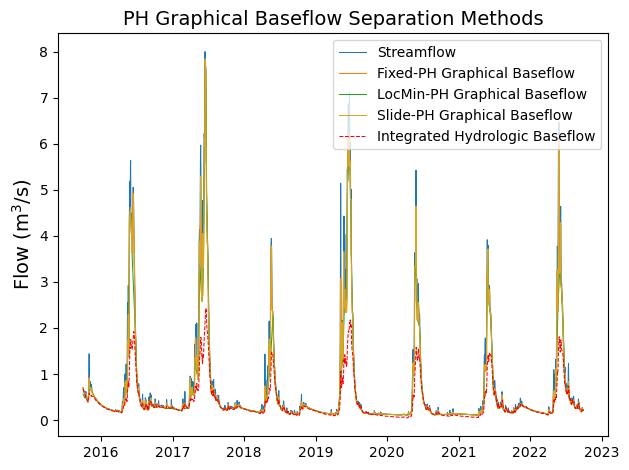

In [84]:
fig, ax = plt.subplots()



ax.plot(combined_df.index, combined_df['streamflow'], label='Streamflow', linewidth=0.75)

ax.plot(combined_df.index, combined_df['Fixed_PH'], label='Fixed-PH Graphical Baseflow', linewidth=0.75)
ax.plot(combined_df.index, combined_df['Local_PH'], label='LocMin-PH Graphical Baseflow', linewidth=0.75)
ax.plot(combined_df.index, combined_df['Slide_PH'], label='Slide-PH Graphical Baseflow', linewidth=0.75, color='#DAA520')
ax.plot(combined_df.index , combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--', linewidth=0.75)




ax.set_title('PH Graphical Baseflow Separation Methods', fontsize = fontsize)
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)



ax.legend()
plt.tight_layout()
plt.savefig('figures/PH Graphical Method.png', dpi=500)
plt.show()

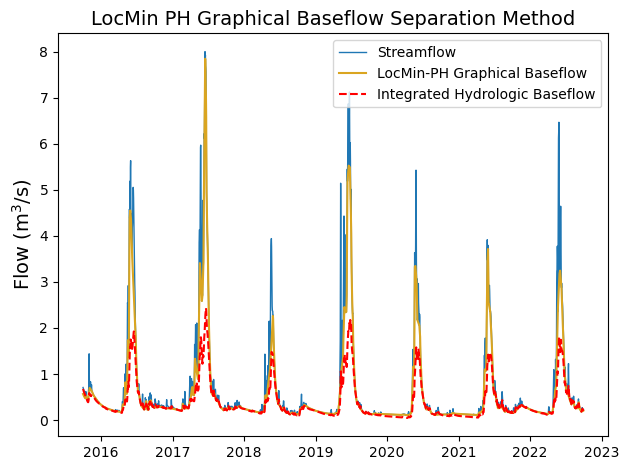

In [85]:
fig, ax = plt.subplots()


ax.plot(combined_df.index, combined_df['streamflow'], label='Streamflow', linewidth=1)
ax.plot(combined_df.index, combined_df['Local_PH'], label='LocMin-PH Graphical Baseflow', color='#DAA520')

ax.plot(combined_df.index , combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--')



ax.set_title('LocMin PH Graphical Baseflow Separation Method', fontsize = fontsize)
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)


plt.tight_layout()
ax.legend()

plt.savefig('figures/locmin-PH Graphical Method.png', dpi=500)

plt.show()

#### Calculate the yearly BFI and its average BFI

In [86]:
methods = [
    'Slide_PH',
    'Fixed_PH',
    'Local_PH'
]

# Resample data by water year (ending in September) or calendar year ('A')
yearly_bfi = combined_df.resample('A-SEP').apply(
    lambda df: {method: (df[method].sum() / df['streamflow'].sum()) for method in methods}
)

# Convert dictionary columns to a DataFrame
yearly_bfi_df = pd.DataFrame(list(yearly_bfi)).set_index(combined_df.resample('A-SEP').sum().index.year)

# Calculate yearly average BFI across methods
yearly_bfi_df['Average_BFI'] = yearly_bfi_df.mean(axis=1)

print(yearly_bfi_df)


      Slide_PH  Fixed_PH  Local_PH  Average_BFI
2016  0.909823  0.902049  0.855028     0.888967
2017  0.903784  0.899213  0.874933     0.892644
2018  0.901235  0.908171  0.802911     0.870772
2019  0.886995  0.893461  0.851681     0.877379
2020  0.905922  0.901982  0.892087     0.899997
2021  0.915295  0.905843  0.904707     0.908615
2022  0.891115  0.878811  0.794907     0.854944


C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\330822519.py:8: FutureWarning: 'A-SEP' is deprecated and will be removed in a future version, please use 'YE-SEP' instead.
  yearly_bfi = combined_df.resample('A-SEP').apply(
C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\330822519.py:13: FutureWarning: 'A-SEP' is deprecated and will be removed in a future version, please use 'YE-SEP' instead.
  yearly_bfi_df = pd.DataFrame(list(yearly_bfi)).set_index(combined_df.resample('A-SEP').sum().index.year)


In [87]:
final_avg_bfis = yearly_bfi_df.mean()

print("Final Average BFI from Yearly Values:")
for method, avg in final_avg_bfis.items():
    print(f"{method}: {avg:.3f}")

Final Average BFI from Yearly Values:
Slide_PH: 0.902
Fixed_PH: 0.899
Local_PH: 0.854
Average_BFI: 0.885


#### Plot zoom in to year 2016

In [88]:
startdate = '2016-04-01'
enddate = '2016-09-01'
PH_combined_df = combined_df.loc[startdate:enddate]

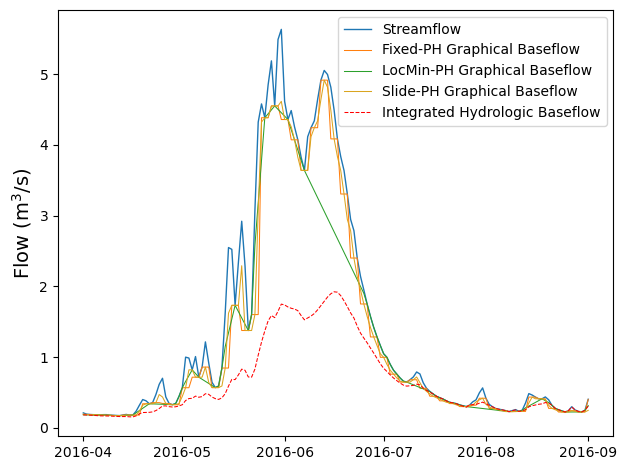

In [89]:
fig, ax = plt.subplots()


ax.plot(PH_combined_df.index, PH_combined_df['streamflow'], label='Streamflow', linewidth=1)

ax.plot(PH_combined_df.index, PH_combined_df['Fixed_PH'], label='Fixed-PH Graphical Baseflow', linewidth=0.75)
ax.plot(PH_combined_df.index, PH_combined_df['Local_PH'], label='LocMin-PH Graphical Baseflow', linewidth=0.75)
ax.plot(PH_combined_df.index, PH_combined_df['Slide_PH'], label='Slide-PH Graphical Baseflow', linewidth=0.75, color='#DAA520')
ax.plot(PH_combined_df.index , PH_combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--', linewidth=0.75)



# ax.set_title('PH Graphical Baseflow Separation Methods', fontsize = fontsize)
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)


plt.tight_layout()
ax.legend()

plt.savefig('figures/PH Graphical Method_all_zoom.png', dpi=500)

plt.show()

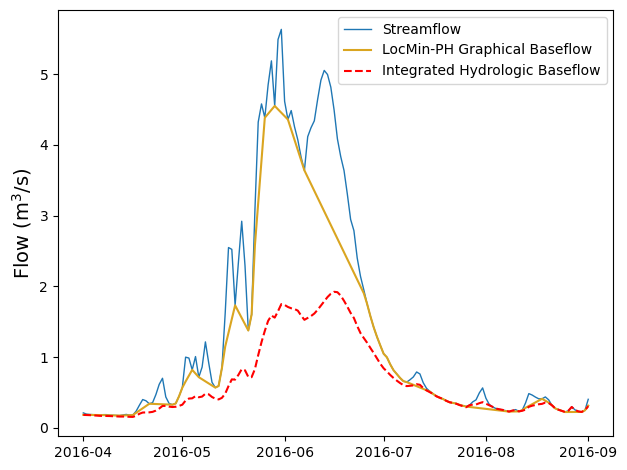

In [90]:
fig, ax = plt.subplots()


ax.plot(PH_combined_df.index, PH_combined_df['streamflow'], label='Streamflow', linewidth=1)

ax.plot(PH_combined_df.index, PH_combined_df['Local_PH'], label='LocMin-PH Graphical Baseflow', color='#DAA520')
ax.plot(PH_combined_df.index , PH_combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--')



ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)


plt.tight_layout()
ax.legend()

plt.savefig('figures/PH Graphical Method_2016.png', dpi=500)

plt.show()

#### Plotting turning points:

In [91]:
# Extract LocMin baseflow series
locmin_series = PH_combined_df['Local_PH']
locmin_index = PH_combined_df.index

# Compute slope
slope = np.diff(locmin_series)

# Set threshold for significant slope change
threshold = 0.001  
slope_diff = np.diff(slope)
significant_change = np.abs(slope_diff) > threshold

# Indices of turning points
turning_idx = np.where(significant_change)[0] + 1  # +1 to correct for diff offset

# Get the corresponding dates and values
turning_dates = locmin_index[turning_idx]
turning_values = locmin_series.iloc[turning_idx]

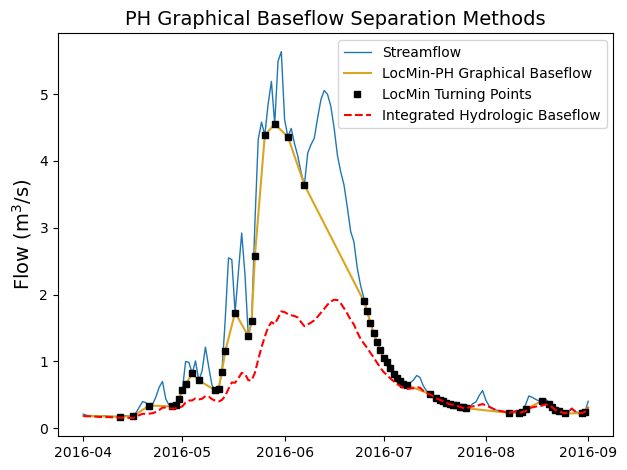

In [92]:
fig, ax = plt.subplots()

# Plot streamflow
ax.plot(PH_combined_df.index, PH_combined_df['streamflow'], label='Streamflow', linewidth=1)

# Plot LocMin baseflow line
ax.plot(PH_combined_df.index, PH_combined_df['Local_PH'], label='LocMin-PH Graphical Baseflow', color='#DAA520')

# Plot turning point markers
ax.plot(turning_dates, turning_values, 'ks', markersize=5, label='LocMin Turning Points')  # black squares

# Plot Integrated Hydrologic Baseflow
ax.plot(PH_combined_df.index, PH_combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--')

# Labels
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize=fontsize)
ax.set_title('PH Graphical Baseflow Separation Methods', fontsize = fontsize)

plt.tight_layout()
ax.legend()

plt.savefig('figures/PH Graphical Method_turning_points.png', dpi=500)
plt.show()


# plot all the baseflow from numerical model, UKIH, HYSEP graphical, digital, numerical, and mass balance method:

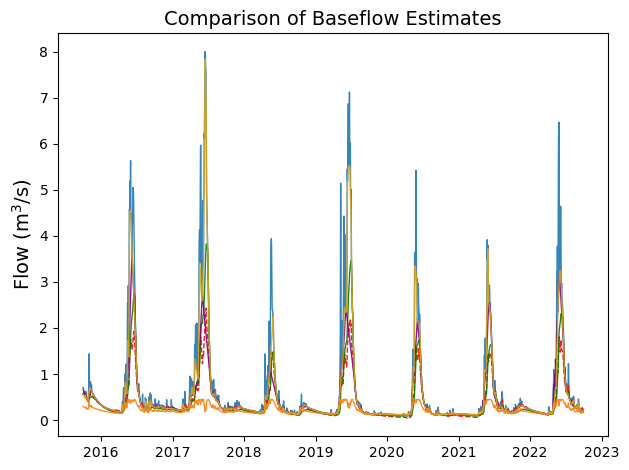

In [93]:
fig, ax = plt.subplots()


ax.plot(combined_df.index, combined_df['streamflow'], label='Streamflow', linewidth=1,alpha = 0.9)

ax.plot(combined_df.index, combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow',color = 'red', linewidth=1,alpha = 0.9, linestyle='--')

ax.plot(combined_df.index, combined_df['Eckhardt_digital'], label='Eckhardt Digital Filter Baseflow', color='green', linewidth=1,alpha = 0.9)

ax.plot(combined_df.index, combined_df['UKIH'], label='UKIH Graphical Baseflow', color = 'purple', linewidth=1,alpha = 0.9)

ax.plot(combined_df.index, combined_df['CMB'], label='Conductance Mass Balance Baseflow', linewidth=1,alpha = 0.9)

ax.plot(combined_df.index, combined_df['Local_PH'], label='LocMin Graphical Baseflow', color='#DAA520', linewidth=1,alpha = 0.9)


# Set the plot title and labels
ax.set_title('Comparison of Baseflow Estimates', fontsize = fontsize)
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)




plt.tight_layout()
plt.savefig('figures/Comparison_of_Baseflow_separation_final.png', dpi=500)

plt.show()

In [94]:
startdate = '2017-02-01'
enddate = '2017-09-01'
filtered_combined_df = combined_df.loc[startdate:enddate]

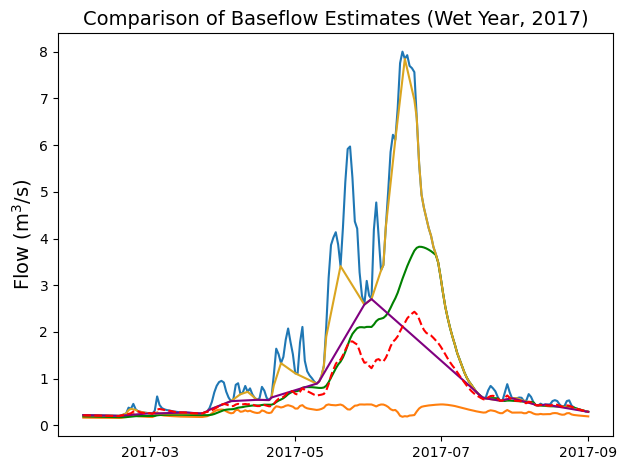

In [95]:
fig, ax = plt.subplots()

ax.plot(filtered_combined_df.index, filtered_combined_df['streamflow'], label='Streamflow')


# Plot simulated baseflow
ax.plot(filtered_combined_df.index, filtered_combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--', zorder=10)
ax.plot(filtered_combined_df.index, filtered_combined_df['CMB'], label='Conductance Mass Balance Baseflow')
ax.plot(filtered_combined_df.index, filtered_combined_df['Eckhardt_digital'], label='Eckhardt Digital Filter Baseflow', color='green')
ax.plot(filtered_combined_df.index, filtered_combined_df['Local_PH'], label='LocMin-Pettyjohn Graphical Baseflow', color='#DAA520')
ax.plot(filtered_combined_df.index, filtered_combined_df['UKIH'], label='UKIH Graphical Baseflow', color = 'purple')

# Set the plot title and labels
ax.set_title('Comparison of Baseflow Estimates (Wet Year, 2017)', fontsize = fontsize)
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # show every 2nd month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format as YYYY-MM

# plt.gcf().autofmt_xdate(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/Comparison_of_Baseflow_Estimates_final_wet_2017.png', dpi=500)

plt.show()

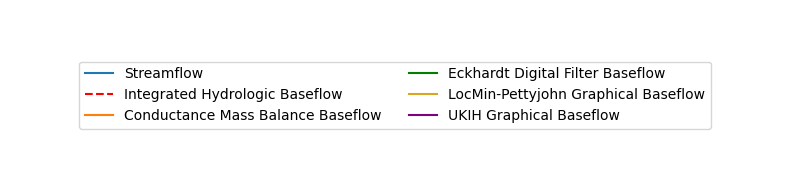

In [96]:
fig_legend = plt.figure(figsize=(8, 2))
ax_legend = fig_legend.add_subplot(111)
fig_legend.legend(*ax.get_legend_handles_labels(), loc='center', ncol=2)
ax_legend.axis('off')
plt.tight_layout()
fig_legend.savefig('figures/Comparison_of_Baseflow_Legend.png', dpi=500, bbox_inches='tight')

plt.show()

In [97]:
startdate = '2021-02-01'
enddate = '2021-09-01'
filtered_combined_df = combined_df.loc[startdate:enddate]

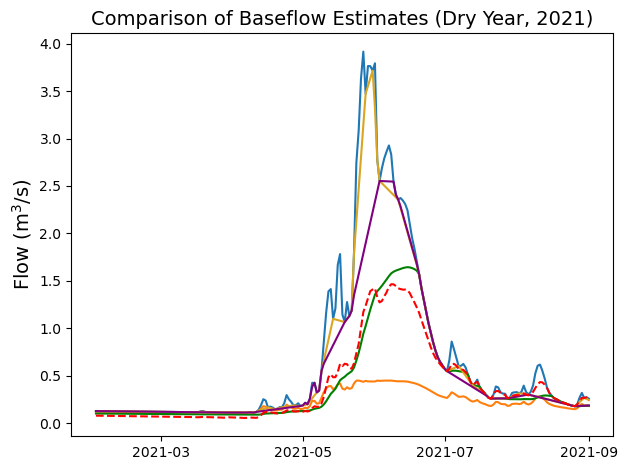

In [98]:
fig, ax = plt.subplots()

ax.plot(filtered_combined_df.index, filtered_combined_df['streamflow'], label='Streamflow')



# Plot simulated baseflow
ax.plot(filtered_combined_df.index, filtered_combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--', zorder=10)
ax.plot(filtered_combined_df.index, filtered_combined_df['CMB'], label='Conductance Mass Balance Baseflow')
ax.plot(filtered_combined_df.index, filtered_combined_df['Eckhardt_digital'], label='Eckhardt Digital Filter Baseflow', color='green')
ax.plot(filtered_combined_df.index, filtered_combined_df['Local_PH'], label='LocMin-Pettyjohn Graphical Baseflow', color='#DAA520')
ax.plot(filtered_combined_df.index, filtered_combined_df['UKIH'], label='UKIH Graphical Baseflow', color = 'purple')

# Set the plot title and labels
ax.set_title('Comparison of Baseflow Estimates (Dry Year, 2021)', fontsize = fontsize)
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # show every 2nd month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format as YYYY-MM

plt.tight_layout()
plt.savefig('figures/Comparison_of_Baseflow_Estimates_final_zoom_dry_2021.png', dpi=500)

plt.show()

In [99]:
startdate = '2016-02-01'
enddate = '2016-09-01'
filtered_combined_df = combined_df.loc[startdate:enddate]

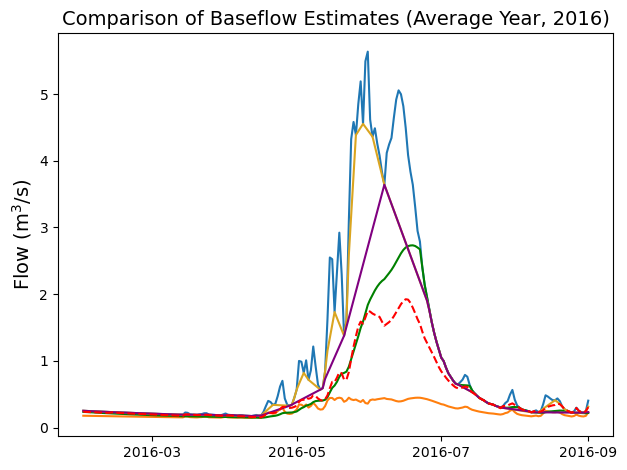

In [100]:
fig, ax = plt.subplots()

ax.plot(filtered_combined_df.index, filtered_combined_df['streamflow'], label='Streamflow')


ax.plot(filtered_combined_df.index, filtered_combined_df['final_baseflow'], label='Integrated Hydrologic Baseflow', color='red', linestyle='--', zorder=10)
ax.plot(filtered_combined_df.index, filtered_combined_df['CMB'], label='Conductance Mass Balance Baseflow')
ax.plot(filtered_combined_df.index, filtered_combined_df['Eckhardt_digital'], label='Eckhardt Digital Filter Baseflow', color='green')
ax.plot(filtered_combined_df.index, filtered_combined_df['Local_PH'], label='LocMin-Pettyjohn Graphical Baseflow', color='#DAA520')
ax.plot(filtered_combined_df.index, filtered_combined_df['UKIH'], label='UKIH Graphical Baseflow', color = 'purple')

# Set the plot title and labels
ax.set_title('Comparison of Baseflow Estimates (Average Year, 2016)', fontsize = fontsize)
ax.set_ylabel(r'Flow (m$^3$/s)', fontsize = fontsize)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # show every 2nd month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format as YYYY-MM

plt.tight_layout()
plt.savefig('figures/Comparison_of_Baseflow_Estimates_final_zoom_avg_2016.png', dpi=500)

plt.show()

### Save combined_df dataframe

In [101]:
combined_df.to_csv('combined_df.csv', index=True)

## Calculate the yearly BFI and its average for each method, , in addition to the NSE and  mKGE of UKIH and Eckhardt baseflow

#### Calculate the yearly BFI and its average

In [102]:
methods = ['final_baseflow', 
           'Eckhardt_digital', 
           'UKIH', 
           'CMB', 
           'Local_PH']

yearly_bfi_df = pd.DataFrame()

for method in methods:
    bf = combined_df[method]
    sf = combined_df['streamflow']
    
    valid_mask = bf.notna()
    bf_valid = bf[valid_mask]
    sf_valid = sf[valid_mask]

    bf_yearly = bf_valid.resample('A-SEP').sum()
    sf_yearly = sf_valid.resample('A-SEP').sum()

    bfi_yearly = (bf_yearly / sf_yearly) * 100
    yearly_bfi_df[method] = bfi_yearly

# convert datetime index to just the year
yearly_bfi_df.index = pd.to_datetime(yearly_bfi_df.index, errors='coerce').year.astype(str)

# Add mean and std rows
yearly_bfi_df.loc['Mean (%)'] = yearly_bfi_df.mean()
yearly_bfi_df.loc['Std (%)'] = yearly_bfi_df.std()

yearly_bfi_df


C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\3141280022.py:17: FutureWarning: 'A-SEP' is deprecated and will be removed in a future version, please use 'YE-SEP' instead.
  bf_yearly = bf_valid.resample('A-SEP').sum()
C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\3141280022.py:18: FutureWarning: 'A-SEP' is deprecated and will be removed in a future version, please use 'YE-SEP' instead.
  sf_yearly = sf_valid.resample('A-SEP').sum()
C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\3141280022.py:17: FutureWarning: 'A-SEP' is deprecated and will be removed in a future version, please use 'YE-SEP' instead.
  bf_yearly = bf_valid.resample('A-SEP').sum()
C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\3141280022.py:18: FutureWarning: 'A-SEP' is deprecated and will be removed in a future version, please use 'YE-SEP' instead.
  sf_yearly = sf_valid.resample('A-SEP').sum()
C:\Users\jihad\AppData\Local\Temp\ipykernel_11068\3141280022.py:17: FutureWarning: 'A-SEP' is deprecated and wil

,final_baseflow,Eckhardt_digital,UKIH,CMB,Local_PH
2016,59.323439,63.913978,74.652774,30.463680,85.502844
2017,51.694184,61.861110,56.546960,23.470208,87.493338
2018,69.449777,64.580180,66.314434,44.789696,80.291136
2019,49.510651,59.414844,56.156587,24.151725,85.168131
2020,56.679591,60.686655,74.198348,38.753429,89.208662
2021,59.852234,61.194122,81.964858,40.418603,90.470680
2022,60.685674,62.339625,79.442821,33.260557,79.490683
Mean (%),58.170793,61.998645,69.896683,33.615414,85.375068
Std (%),6.057630,1.669586,9.693386,7.560169,3.885509


#### Plot the yearly BFI histogram of the numerical method baseflow BFI

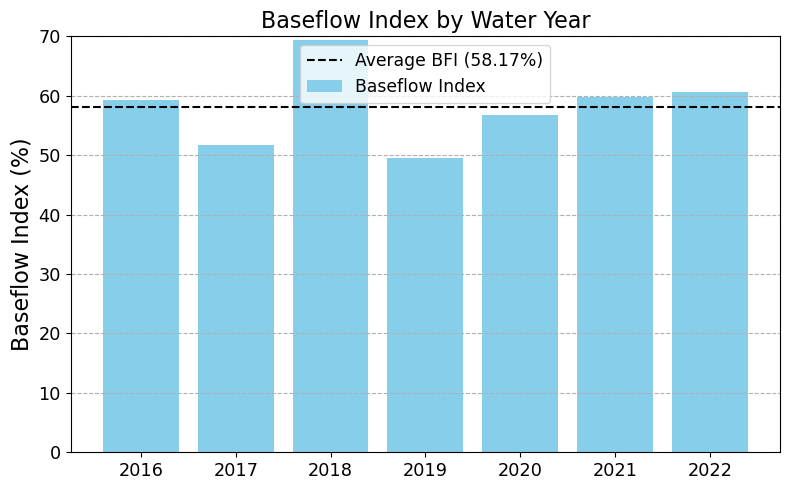

In [103]:
# Drop the summary rows and extract data
plot_df = yearly_bfi_df.drop(index=['Mean (%)', 'Std (%)'], errors='ignore')

# Convert index to integer years (if needed)
years = plot_df.index.astype(int)

# Extract final_baseflow BFI values
baseflow_index = plot_df['final_baseflow'].values

# Compute average
avg_baseflow = np.mean(baseflow_index)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(years, baseflow_index, color='skyblue', label='Baseflow Index')

# Add average line
plt.axhline(y=avg_baseflow, color='black', linestyle='--', label=f'Average BFI ({avg_baseflow:.2f}%)')

# Labels and title
plt.ylabel('Baseflow Index (%)', fontsize=16)
plt.title('Baseflow Index by Water Year', fontsize=16)
plt.ylim(0, 70)
plt.legend(fontsize=12.4)
plt.tick_params(axis='both', labelsize=12.7)
plt.grid(axis='y', linestyle='--')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save figure
plt.savefig('figures/baseflow_index_histogram.png', dpi=500)

# Show plot
plt.show()


In [104]:
def nse(obs, sim):
    obs = np.asarray(obs, dtype=float)
    sim = np.asarray(sim, dtype=float)
    return 1 - np.sum((obs - sim) ** 2) / np.sum((obs - np.mean(obs)) ** 2)

In [105]:
try:
    from modvis.objectivefunctions import mkge as _mkge_pkg

    def mkge(sim, obs):
        # Note: modvis signature is (evaluation, simulation)
        return _mkge_pkg(np.asarray(obs, dtype=float), np.asarray(sim, dtype=float))

except ImportError:
    def mkge(sim, obs):
        sim = np.asarray(sim, dtype=float)
        obs = np.asarray(obs, dtype=float)

        r = np.corrcoef(sim, obs)[0, 1]


        cv_sim = np.std(sim) / (np.mean(sim))
        cv_obs = np.std(obs) / (np.mean(obs))
        alpha = cv_sim / (cv_obs)
        beta = (np.mean(sim)) / (np.mean(obs))
        
        return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

In [106]:
years_to_analyze = ['2016', '2017', '2018', '2019', '2020', '2021']  # adjust if needed
results = []

In [107]:
for year in years_to_analyze:
    # Water year: Oct 1 (prev year) -> Sep 30 (this year)
    start_date = f"{int(year)-1}-10-01"
    end_date   = f"{year}-09-30"

    # Extract & align series
    model    = combined_df['final_baseflow'].loc[start_date:end_date]
    eckhardt = combined_df['Eckhardt_digital'].loc[start_date:end_date]
    ukih     = combined_df['UKIH'].loc[start_date:end_date]

    # Pairwise complete cases
    df = pd.concat([model, eckhardt, ukih], axis=1).dropna()
    if df.empty:
        results.append({
            'Water Year': year,
            'NSE_Eckhardt': np.nan,
            'NSE_UKIH': np.nan,
            'mKGE_Eckhardt': np.nan,
            'mKGE_UKIH': np.nan
        })
        continue

    model, eckhardt, ukih = df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]

    # Metrics (model is the "observation/target")
    nse_eck     = nse(model, eckhardt)
    nse_ukih    = nse(model, ukih)
    mkge_eck    = mkge(eckhardt, model)
    mkge_ukih   = mkge(ukih, model)

    results.append({
        'Water Year'      : year,
        'NSE_Eckhardt'    : round(nse_eck, 3),
        'NSE_UKIH'        : round(nse_ukih, 3),
        'mKGE_Eckhardt'   : round(mkge_eck, 3),
        'mKGE_UKIH'       : round(mkge_ukih, 3),
    })

In [108]:
nse_mkge_df = pd.DataFrame(results)
display(nse_mkge_df)

,Water Year,NSE_Eckhardt,NSE_UKIH,mKGE_Eckhardt,mKGE_UKIH
0,2016,0.725,0.118,0.654,0.484
1,2017,0.386,0.748,0.542,0.841
2,2018,0.947,0.777,0.837,0.800
3,2019,0.612,0.777,0.653,0.842
4,2020,0.923,0.782,0.906,0.689
5,2021,0.951,0.423,0.933,0.586


mKGE: 0.2499701690481987, cc:  0.8519779426766428, alpha:  0.41874302599003654, beta:  0.5496950499626624


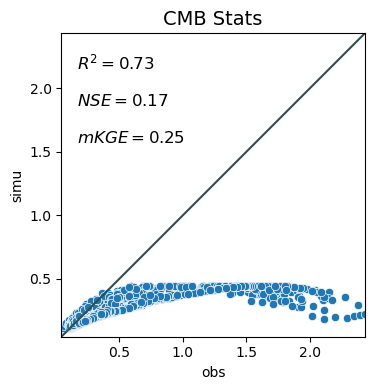

In [109]:
# One-to-one plots 
valid_data = combined_df.dropna(subset=['final_baseflow'])

gp.one2one_plot(
    valid_data['final_baseflow'],
    valid_data['CMB'],
    metrics=['R^2', 'NSE', 'mKGE'],
    show_density=False,
    start_date="2015-10-01",
    decompose_KGE=True
)
plt.title('CMB Stats', fontsize=14)
plt.tight_layout()

mKGE: 0.6755915629676941, cc:  0.9647527474116963, alpha:  1.3093791491199542, beta:  1.0910110284115782


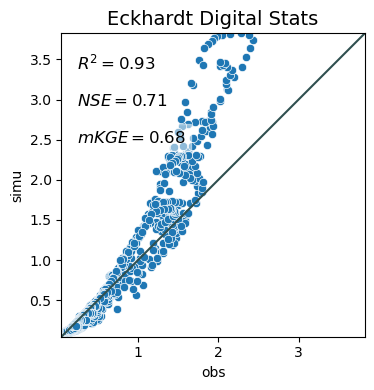

In [110]:
valid_data = combined_df.dropna(subset=['final_baseflow'])
gp.one2one_plot(
    valid_data['final_baseflow'],
    valid_data['Eckhardt_digital'],
    metrics=['R^2', 'NSE', 'mKGE'],
    show_density=False,
    start_date="2015-10-01",
    decompose_KGE=True
)
plt.title('Eckhardt Digital Stats', fontsize=14)
plt.tight_layout()

mKGE: 0.7269671558477855, cc:  0.9214742817833407, alpha:  1.176586832507315, beta:  1.1928671463713785


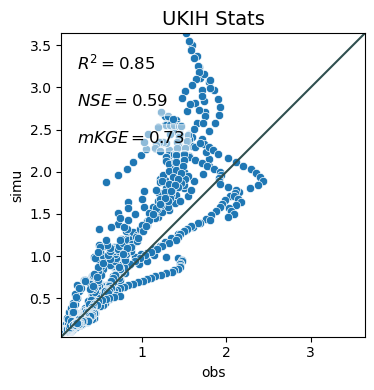

In [111]:
valid_data = combined_df.dropna(subset=['final_baseflow'])
gp.one2one_plot(
    valid_data['final_baseflow'],
    valid_data['UKIH'],
    metrics=['R^2', 'NSE', 'mKGE'],
    show_density=False,
    start_date="2015-10-01",
    decompose_KGE=True
)
plt.title('UKIH Stats', fontsize=14)
plt.tight_layout()

mKGE: 0.2660092324243718, cc:  0.9358655484257732, alpha:  1.528833756114726, beta:  1.5049396769923349


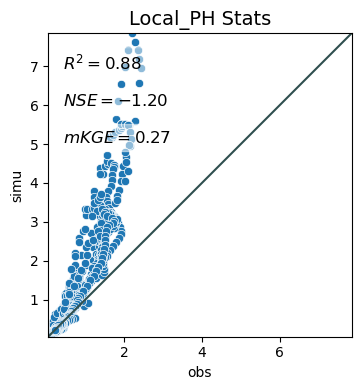

In [112]:
valid_data = combined_df.dropna(subset=['final_baseflow'])
gp.one2one_plot(
    valid_data['final_baseflow'],
    valid_data['Local_PH'],
    metrics=['R^2', 'NSE', 'mKGE'],
    show_density=False,
    start_date="2015-10-01",
    decompose_KGE=True
)
plt.title('Local_PH Stats', fontsize=14)
plt.tight_layout()